In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import requests
import folium
import missingno as msno

%matplotlib inline

In [2]:
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

In [3]:
df = pd.read_csv('loan_data.csv', low_memory=False)

In [4]:
X, y = df.loc[:, [column for column in df.columns if column != "loan_status"]], df.loan_status
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1, random_state=6, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.1, random_state=6, stratify=y_1)
EDA = pd.concat((X_train, y_train), axis=1)

In [5]:
#제거 확정 변수 
remove = ['member_id','out_prncp', 'out_prncp_inv', 
          'issue_d','earliest_cr_line','sec_app_earliest_cr_line','last_pymnt_d','next_pymnt_d',
          'payment_plan_start_date','initial_list_status','verification_status_joint','disbursement_method','application_type','purpose',
         'collection_recovery_fee','delinq_amnt','total_rec_late_fee','tot_coll_amt','recoveries',
         'total_pymnt_inv','total_pymnt','total_rec_prncp','total_rec_int','funded_amnt','funded_amnt_inv','orig_projected_additional_accrued_interest',
         'last_pymnt_amnt','sec_app_open_acc','sec_app_mort_acc','sec_app_open_act_il','dti_joint','sec_app_revol_util']






In [6]:
#EDA 그룹
target = 'loan_status'
#명목형
##1
info =['hardship_status','debt_settlement_flag','application_type', 'addr_state',
      'term', 'verification_status',
      'grade','collection_recovery_fee'] #여부로 변경 (n,y)

#신용위험 횟수 
##3
risk = ['inq_last_6mths','delinq_2yrs']

##2
loan = ['avg_cur_bal', 'funded_amnt','int_rate','fico_range_low',
         'open_rv_24m','open_il_24m','num_actv_bc_tl','num_actv_rev_tl',
         'revol_util','bc_util', 'il_util'] #지난 납부 잔액

In [7]:
EDA[info+risk+loan].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1089701 entries, 1126992 to 162341
Data columns (total 21 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   hardship_status          4655 non-null     object 
 1   debt_settlement_flag     1089701 non-null  object 
 2   application_type         1089701 non-null  object 
 3   addr_state               1089701 non-null  object 
 4   term                     1089701 non-null  object 
 5   verification_status      1089701 non-null  object 
 6   grade                    1089701 non-null  object 
 7   collection_recovery_fee  1089701 non-null  float64
 8   inq_last_6mths           1089701 non-null  float64
 9   delinq_2yrs              1089701 non-null  float64
 10  avg_cur_bal              1035008 non-null  float64
 11  funded_amnt              1089701 non-null  float64
 12  int_rate                 1089701 non-null  float64
 13  fico_range_low           1089701 non-null 

In [7]:
EDA['verification_status'].value_counts()

verification_status
Source Verified    422408
Verified           338671
Not Verified       328622
Name: count, dtype: int64

### 'collection_recovery_fee' 여부로 컬럼 전처리

In [8]:
EDA['collection_recovery_fee_flag'] = EDA['collection_recovery_fee']
EDA['collection_recovery_fee_flag']

1126992      0.0000
530674       0.0000
465057       0.0000
148918      80.4420
31145        0.0000
             ...   
1187260      0.0000
673511     357.9732
509553       0.0000
107784       0.0000
162341       0.0000
Name: collection_recovery_fee_flag, Length: 1089701, dtype: float64

In [9]:
EDA['collection_recovery_fee_flag'] = EDA['collection_recovery_fee']

In [10]:
EDA['collection_recovery_fee_flag']

1126992      0.0000
530674       0.0000
465057       0.0000
148918      80.4420
31145        0.0000
             ...   
1187260      0.0000
673511     357.9732
509553       0.0000
107784       0.0000
162341       0.0000
Name: collection_recovery_fee_flag, Length: 1089701, dtype: float64

In [11]:
EDA['collection_recovery_fee_flag'] = EDA['collection_recovery_fee']
EDA.loc[EDA['collection_recovery_fee_flag']!=0, 'collection_recovery_fee_flag'] = 'y'
EDA.loc[EDA['collection_recovery_fee_flag']==0, 'collection_recovery_fee_flag'] = 'n'

C:\Users\medici\AppData\Local\Temp\ipykernel_2404\2896500357.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'y' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  EDA.loc[EDA['collection_recovery_fee_flag']!=0, 'collection_recovery_fee_flag'] = 'y'


In [12]:
EDA['collection_recovery_fee_flag'].value_counts()

collection_recovery_fee_flag
n    946609
y    143092
Name: count, dtype: int64

In [13]:
#명목형 컬럼 EDA를 위한 함수 설계

#명목형 unique 값의 갯수를 세고, n개 미만이면 unique 값을 출력하는 함수
def print_uv(group,n):
    for col in group:
        nu = EDA[col].nunique()
        print(f'{col} NU: {nu}')
        if nu < n :
            print(EDA[col].unique(), '\n')
        else:
            print('!!!TOO MANY!!!\n', EDA[col].unique()[1:5])

        print('-'*70)


#긴 명목형 값을 그래프에 45도로 출력하는 함수
def set_xticklabels(ax):
    for a in ax:
        ticks = range(len(a.get_xticks()))
        a.set_xticks(ticks)
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')

## 분포 EDA

In [14]:
cat_feature = EDA[info+risk+loan+['collection_recovery_fee_flag']].select_dtypes(exclude=np.number).columns.tolist()
cat_feature

['hardship_status',
 'debt_settlement_flag',
 'application_type',
 'addr_state',
 'term',
 'verification_status',
 'grade',
 'collection_recovery_fee_flag']

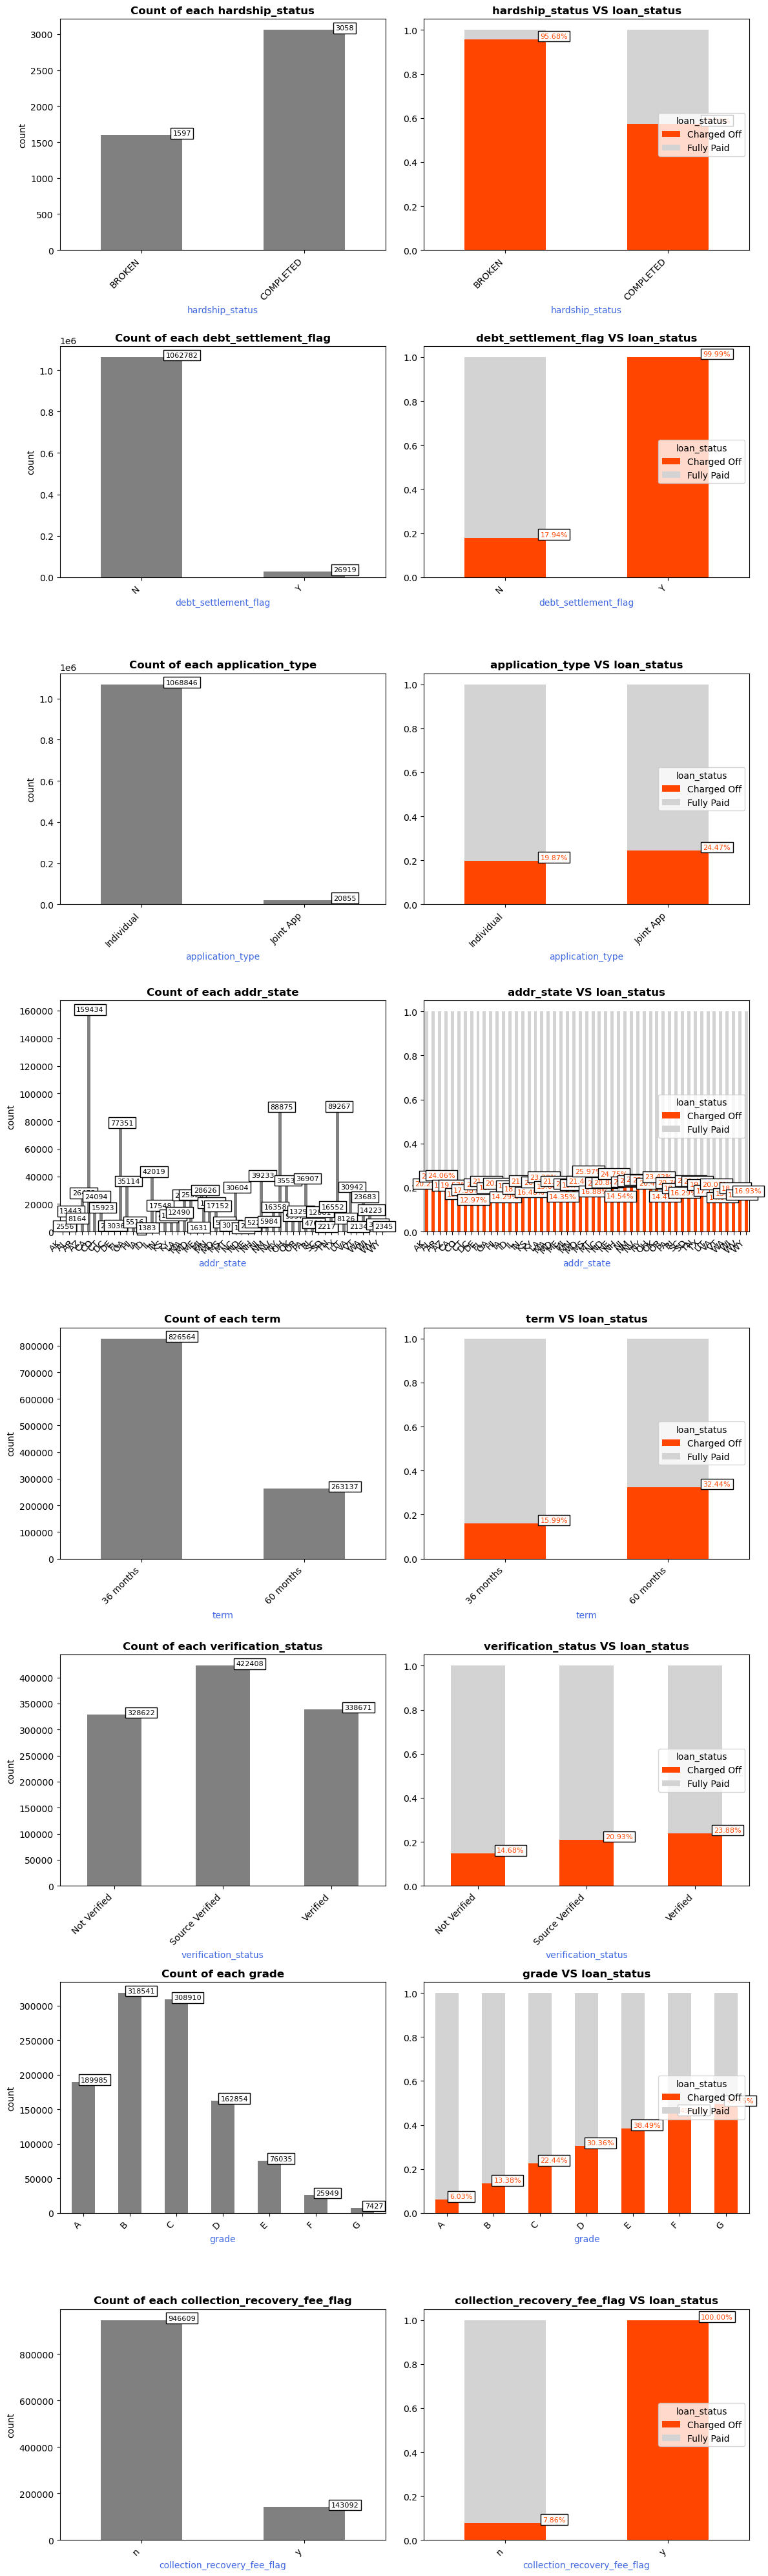

In [15]:
fig, ax = plt.subplots(len(cat_feature), 2, figsize=(12, 5*len(cat_feature)))
for idx, col in enumerate(cat_feature):
    ax1 = sns.countplot(data=EDA[cat_feature + [target]], x=col, order=np.sort(EDA[col].dropna().unique()), 
                        width=0.5, ax=ax[idx, 0], color='gray')
    ax1.set_title(f"Count of each {col}",size=12, weight="bold")
    font1 = {'color':'royalblue','size':10, 'rotation':360}
    ax1.set_xlabel(col, fontdict=font1)

    # 타겟에 대한 컬럼의 범주별 비율 계산
    prop_df = pd.crosstab(EDA[col], EDA[target], normalize='index')
    ax2 = prop_df.plot(kind='bar', stacked=True, ax=ax[idx, 1], color=['orangered','lightgray'])
    ax2.set_title(f"{col} VS {target}", size=12, weight="bold")
    font2 = { 'color':'royalblue','size':10, 'rotation':360}
    ax2.set_xlabel(col,fontdict=font2)
    ax2.legend(title=target, loc='center right')

    
    for bar1, bar2 in zip(ax1.patches, ax2.patches):
        bbox_props = dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white")  # 네모 박스 스타일 정의
        ax1.text(bar1.get_x() + bar1.get_width(), bar1.get_height(), int(bar1.get_height()), 
                 ha="center", size=8,bbox=bbox_props)
        ax2.text(bar2.get_x() + bar2.get_width()+0.05 , bar2.get_height(), f'{bar2.get_height():.2%}',
                 ha='center', va='bottom', size=8, color='orangered',bbox=bbox_props)
        


# 눈금 레이블 회전 설정
set_xticklabels(ax[:, 0])
set_xticklabels(ax[:, 1])

# xticks 크기 조정
plt.xticks(fontsize=10)


plt.tight_layout()
plt.show()

## 미국주별 대출 미상환 비율 시각화 

In [16]:
# 주소 별 대출 상태에 따른 개수 계산
state_geo = requests.get("https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json").json() # US states
state_counts = EDA.groupby(by=['addr_state','loan_status']).size().reset_index(name='count')
# 주소별 대출 미상환 비율 계산
state_counts['Charged Off Rate'] = [round((state_counts.loc[(state_counts['addr_state'] ==  a) & (state_counts['loan_status'] == 'Charged Off'),"count"].iloc[0] / 
                                    (state_counts.loc[(state_counts['addr_state'] ==  a), "count"].iloc[0]+ state_counts.loc[(state_counts['addr_state'] ==  a), 
                                    "count"].iloc[1])) *100,2)
                              for a in state_counts['addr_state']]

# 미상환(Charged Off) 데이터 행만 추출
df = state_counts.loc[state_counts['loan_status']=='Charged Off'].reset_index()
#  지도시각화 필요한 데이터만 추출
m_df = df[['addr_state','Charged Off Rate']]

In [17]:
m = folium.Map([48, -102], zoom_start=3)
cp = folium.Choropleth(geo_data=state_geo, 
                  data=m_df, 
                  columns=m_df.columns, 
                  key_on="feature.id", #데이터들끼리 연결할 key지정
                  bins=m_df["Charged Off Rate"].quantile([0, 0.25, 0.5, 0.75, 1]).to_list(), 
                  fill_color='PuRd', 
                  line_weight=0.7, 
                  line_opacity=0.4, 
                  name="US Cholopleth Map", 
                  fill_opacity = 0.7, # 색칠 투명도
                  legend_name="Charged Off Rate (%)").add_to(m)

# Choropleth Map에 Tooltip 추가
for data in cp.geojson.data.get("features"):
    data.get("properties")["id"] = f"{data.get('properties').get('name')} ({data.get('id')})"
    data.get("properties")["rate"] = m_df[m_df.addr_state == data.get("id")]["Charged Off Rate"].values.round(2)[0]
    folium.GeoJsonTooltip(fields=["id", "rate"], aliases=["State Name", "Charge Off rate (%)"], style="font-size: 12px").add_to(cp.geojson)
m

## 결측치 탐색

In [18]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["변수명", "결측치 개수", "전체 비율"]

for col in info + risk + loan:
    na_cnt = EDA[col].isna().sum()
    total_rows = EDA.shape[0]
    ratio = (na_cnt / total_rows) * 100
    if na_cnt != 0:
        table.add_row([col, na_cnt, f'{ratio:.2f}%'])

In [ ]:
accepted[fico_range_low'].isna().sum()

In [481]:
accepted['grade'].isna().sum()

33

In [482]:
accepted['fico_range_high'].isna().sum()

33

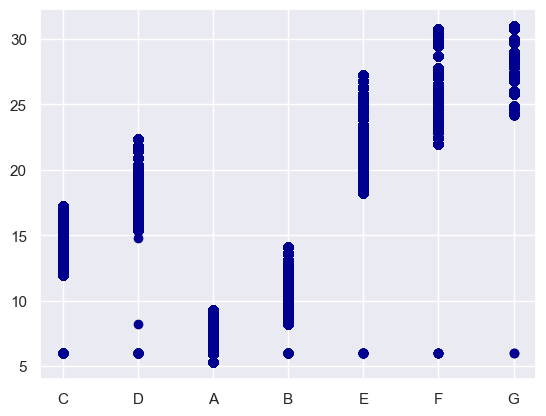

In [487]:
plt.scatter(y=EDA['int_rate'], x=EDA['grade']);

In [19]:
table

변수명,결측치 개수,전체 비율
hardship_status,1085046,99.57%
avg_cur_bal,54693,5.02%
open_rv_24m,654028,60.02%
open_il_24m,654028,60.02%
num_actv_bc_tl,54676,5.02%
num_actv_rev_tl,54676,5.02%
revol_util,698,0.06%
bc_util,50287,4.61%
il_util,712908,65.42%


### 1. hardship_status 결측치 탐색 : 새로운 범주로 지정

In [20]:
hardship = ['hardship_amount',
             'hardship_status',
             'hardship_reason',
             'hardship_loan_status',
             'hardship_last_payment_amount',
             'hardship_payoff_balance_amount']

In [21]:
EDA[hardship].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1089701 entries, 1126992 to 162341
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hardship_amount                 4655 non-null   float64
 1   hardship_status                 4655 non-null   object 
 2   hardship_reason                 4655 non-null   object 
 3   hardship_loan_status            4655 non-null   object 
 4   hardship_last_payment_amount    4655 non-null   float64
 5   hardship_payoff_balance_amount  4655 non-null   float64
dtypes: float64(3), object(3)
memory usage: 58.2+ MB


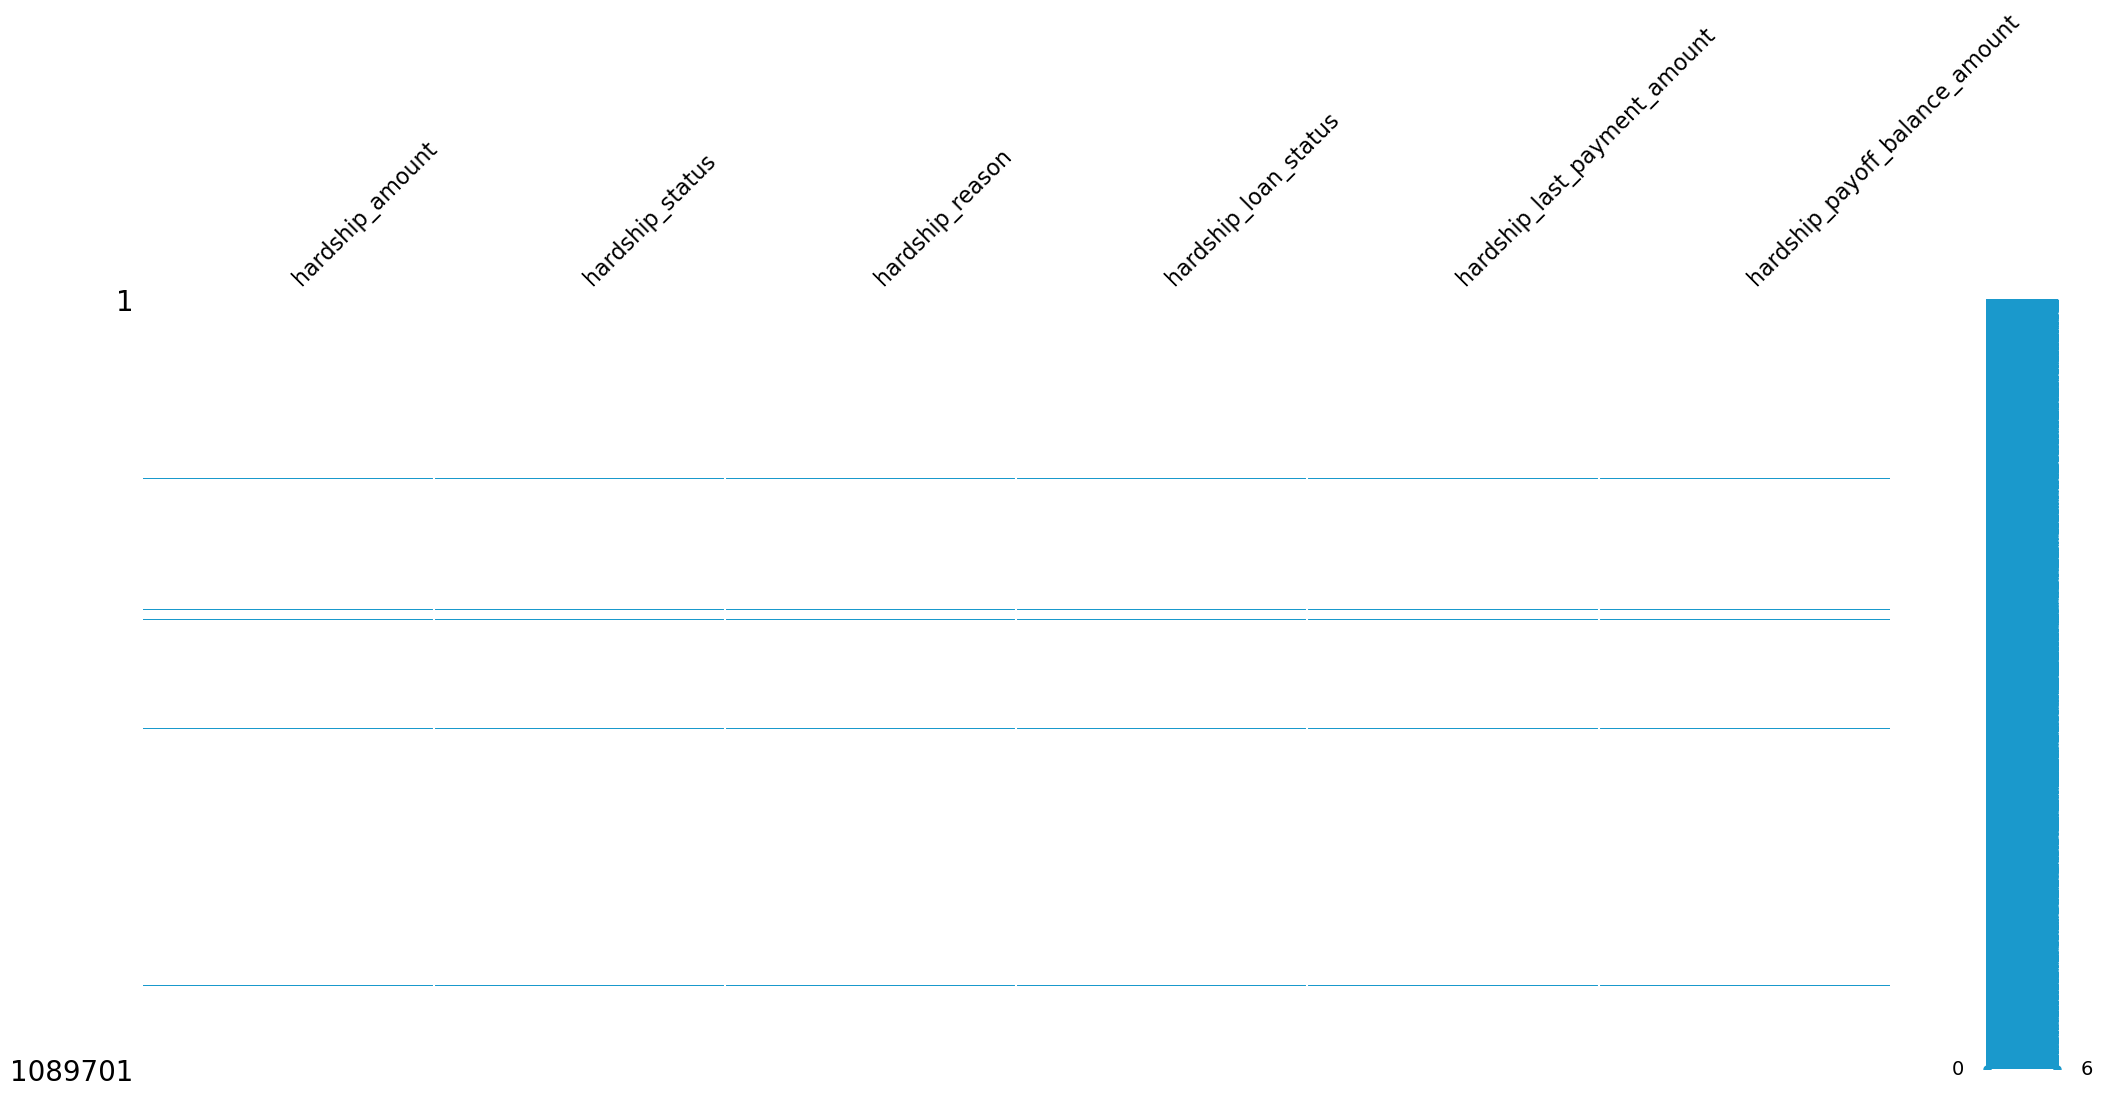

In [22]:
msno.matrix(df=EDA[hardship], color=(0.1, 0.6, 0.8));

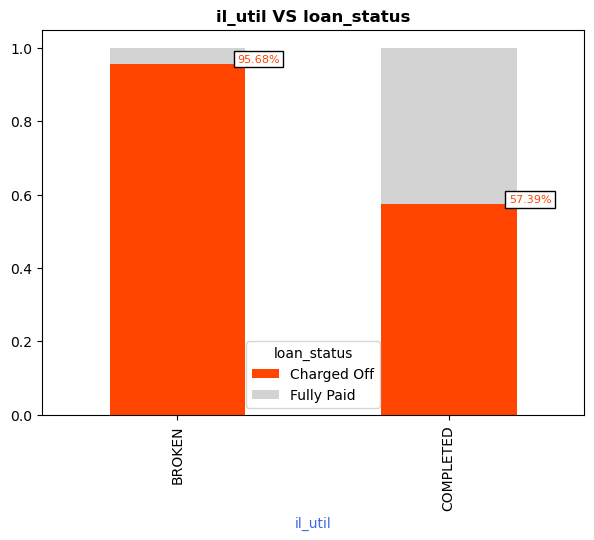

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

prop_df = pd.crosstab(EDA['hardship_status'], EDA[target], normalize='index')
ax2 = prop_df.plot(kind='bar', stacked=True, ax=ax, color=['orangered','lightgray'])
ax2.set_title(f"{col} VS {target}", size=12, weight="bold")
font2 = { 'color':'royalblue','size':10, 'rotation':360}
ax2.set_xlabel(col,fontdict=font2)
ax2.legend(title=target)

for bar1, bar2 in zip(ax1.patches, ax2.patches):
    bbox_props = dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white")  # 네모 박스 스타일 정의

    ax2.text(bar2.get_x() + bar2.get_width()+0.05 , bar2.get_height(), f'{bar2.get_height():.2%}',
             ha='center', va='bottom', size=8, color='orangered',bbox=bbox_props)
        

plt.show()

- hardship 관련 컬럼에 전부 같은 결측치 개수와 같은 위치
- hardship 결측치의 의미 : hardship 경험하지 않았다고 판단되어짐.
- 결측값 : 'NONE' 으로 대체
-> BROKEN, COMPLETED. NONE

In [24]:
EDA['hardship_status'] = EDA['hardship_status'].fillna('NONE')
EDA['hardship_status']

1126992    NONE
530674     NONE
465057     NONE
148918     NONE
31145      NONE
           ... 
1187260    NONE
673511     NONE
509553     NONE
107784     NONE
162341     NONE
Name: hardship_status, Length: 1089701, dtype: object

In [25]:
for i in ax2.patches[:3]:
    print(i)

Rectangle(xy=(-0.25, 0), width=0.5, height=0.956794, angle=0)
Rectangle(xy=(0.75, 0), width=0.5, height=0.573905, angle=0)
Rectangle(xy=(-0.25, 0.956794), width=0.5, height=0.043206, angle=0)


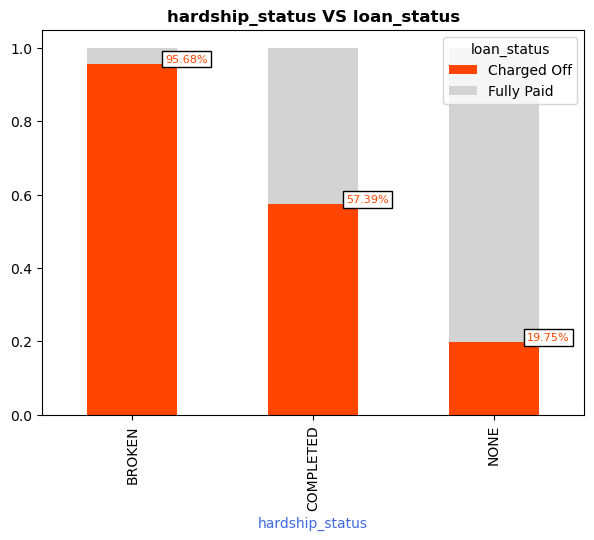

In [26]:
#결측치 대체
fig, ax = plt.subplots(figsize=(7, 5))

prop_df = pd.crosstab(EDA['hardship_status'], EDA[target], normalize='index')
ax2 = prop_df.plot(kind='bar', stacked=True, ax=ax, color=['orangered','lightgray'])
ax2.set_title(f"{'hardship_status'} VS {target}", size=12, weight="bold")
font2 = { 'color':'royalblue','size':10, 'rotation':360}
ax2.set_xlabel('hardship_status',fontdict=font2)
ax2.legend(title=target)

for  bar2 in ax2.patches[:3]:
    bbox_props = dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white")  # 네모 박스 스타일 정의

    ax2.text(bar2.get_x() + bar2.get_width()+0.05 , bar2.get_height(), f'{bar2.get_height():.2%}',
             ha='center', va='bottom', size=8, color='orangered',bbox=bbox_props)
        

plt.show()

### 2. avg_cur_bal 결측치 탐색

In [27]:
##1
credit_balance = ['tot_cur_bal','avg_cur_bal',
                  'all_util','bc_open_to_buy','max_bal_bc',
                  'tot_hi_cred_lim','total_bc_limit', #한도
                  'total_pymnt_inv','total_pymnt','total_rec_prncp','total_rec_int',
                  'total_bal_ex_mort','total_bal_il','revol_bal']  #갚을잔액 

##7
accts = ['total_acc','open_acc_6m','acc_open_past_24mths','open_rv_24m','open_il_24m','num_tl_op_past_12m','open_rv_12m','open_il_12m',
         'total_acc','total_cu_tl','num_rev_accts','num_il_tl','mort_acc',
         'num_sats','pct_tl_nvr_dlq',
         'open_acc','open_act_il','num_op_rev_tl','num_rev_tl_bal_gt_0',
         'acc_now_delinq','num_tl_30dpd','num_tl_120dpd_2m','num_accts_ever_120_pd']

In [28]:
EDA[credit_balance+accts].corr()['avg_cur_bal'].abs().sort_values(ascending=False)

avg_cur_bal              1.000000
tot_cur_bal              0.834665
tot_hi_cred_lim          0.796686
mort_acc                 0.459029
total_bal_ex_mort        0.288602
revol_bal                0.282614
max_bal_bc               0.258804
total_rec_prncp          0.235421
total_pymnt_inv          0.226007
total_pymnt              0.225986
total_bal_il             0.196133
num_op_rev_tl            0.192848
open_rv_24m              0.192498
num_rev_tl_bal_gt_0      0.158521
open_rv_12m              0.146343
total_bc_limit           0.139644
num_sats                 0.111539
open_acc                 0.111525
total_rec_int            0.095301
all_util                 0.092024
num_rev_accts            0.080752
acc_open_past_24mths     0.078453
total_cu_tl              0.062754
total_acc                0.053632
total_acc                0.053632
num_tl_op_past_12m       0.050592
num_il_tl                0.048830
bc_open_to_buy           0.045421
open_act_il              0.043998
pct_tl_nvr_dlq

In [29]:
EDA[credit_balance+accts].isna().sum()

tot_cur_bal               54676
avg_cur_bal               54693
all_util                 654075
bc_open_to_buy            49653
max_bal_bc               654028
tot_hi_cred_lim           54676
total_bc_limit            38350
total_pymnt_inv               0
total_pymnt                   0
total_rec_prncp               0
total_rec_int                 0
total_bal_ex_mort         38350
total_bal_il             654028
revol_bal                     0
total_acc                     0
open_acc_6m              654028
acc_open_past_24mths      38350
open_rv_24m              654028
open_il_24m              654028
num_tl_op_past_12m        54676
open_rv_12m              654028
open_il_12m              654028
total_acc                     0
total_cu_tl              654028
num_rev_accts             54677
num_il_tl                 54676
mort_acc                  38350
num_sats                  45270
pct_tl_nvr_dlq            54801
open_acc                      0
open_act_il              654028
num_op_r

In [30]:
avg_df = EDA[['tot_cur_bal','avg_cur_bal','total_acc','num_rev_accts','num_il_tl','mort_acc', 'num_sats', 'open_acc','open_act_il','num_op_rev_tl','num_rev_tl_bal_gt_0']]
avg_df.isna().sum()

tot_cur_bal             54676
avg_cur_bal             54693
total_acc                   0
num_rev_accts           54677
num_il_tl               54676
mort_acc                38350
num_sats                45270
open_acc                    0
open_act_il            654028
num_op_rev_tl           54676
num_rev_tl_bal_gt_0     54676
dtype: int64

In [31]:
#total_acc = num_rev_accts+num_il_tl+mort_acc
#open_acc =  open_act_il+num_op_rev_tl
avg_df.head(10)

,tot_cur_bal,avg_cur_bal,total_acc,num_rev_accts,num_il_tl,mort_acc,num_sats,open_acc,open_act_il,num_op_rev_tl,num_rev_tl_bal_gt_0
1126992,18861.0,3144.0,16.0,14.0,2.0,0.0,7.0,7.0,NaN,7.0,6.0
530674,180593.0,12040.0,21.0,15.0,1.0,5.0,15.0,15.0,1.0,13.0,8.0
465057,131188.0,14576.0,38.0,4.0,34.0,0.0,9.0,9.0,5.0,4.0,1.0
148918,76482.0,5099.0,22.0,12.0,10.0,0.0,15.0,15.0,NaN,11.0,9.0
31145,486746.0,54083.0,18.0,12.0,3.0,3.0,8.0,9.0,NaN,7.0,5.0
37221,6762.0,1352.0,6.0,4.0,2.0,0.0,6.0,6.0,NaN,4.0,3.0
343684,21526.0,3588.0,8.0,6.0,2.0,0.0,6.0,6.0,NaN,4.0,3.0
1140706,862684.0,107836.0,36.0,17.0,13.0,5.0,10.0,10.0,NaN,6.0,3.0
290496,223337.0,22334.0,26.0,14.0,5.0,7.0,10.0,10.0,NaN,8.0,6.0
624084,32784.0,3643.0,16.0,7.0,9.0,0.0,9.0,9.0,6.0,3.0,2.0


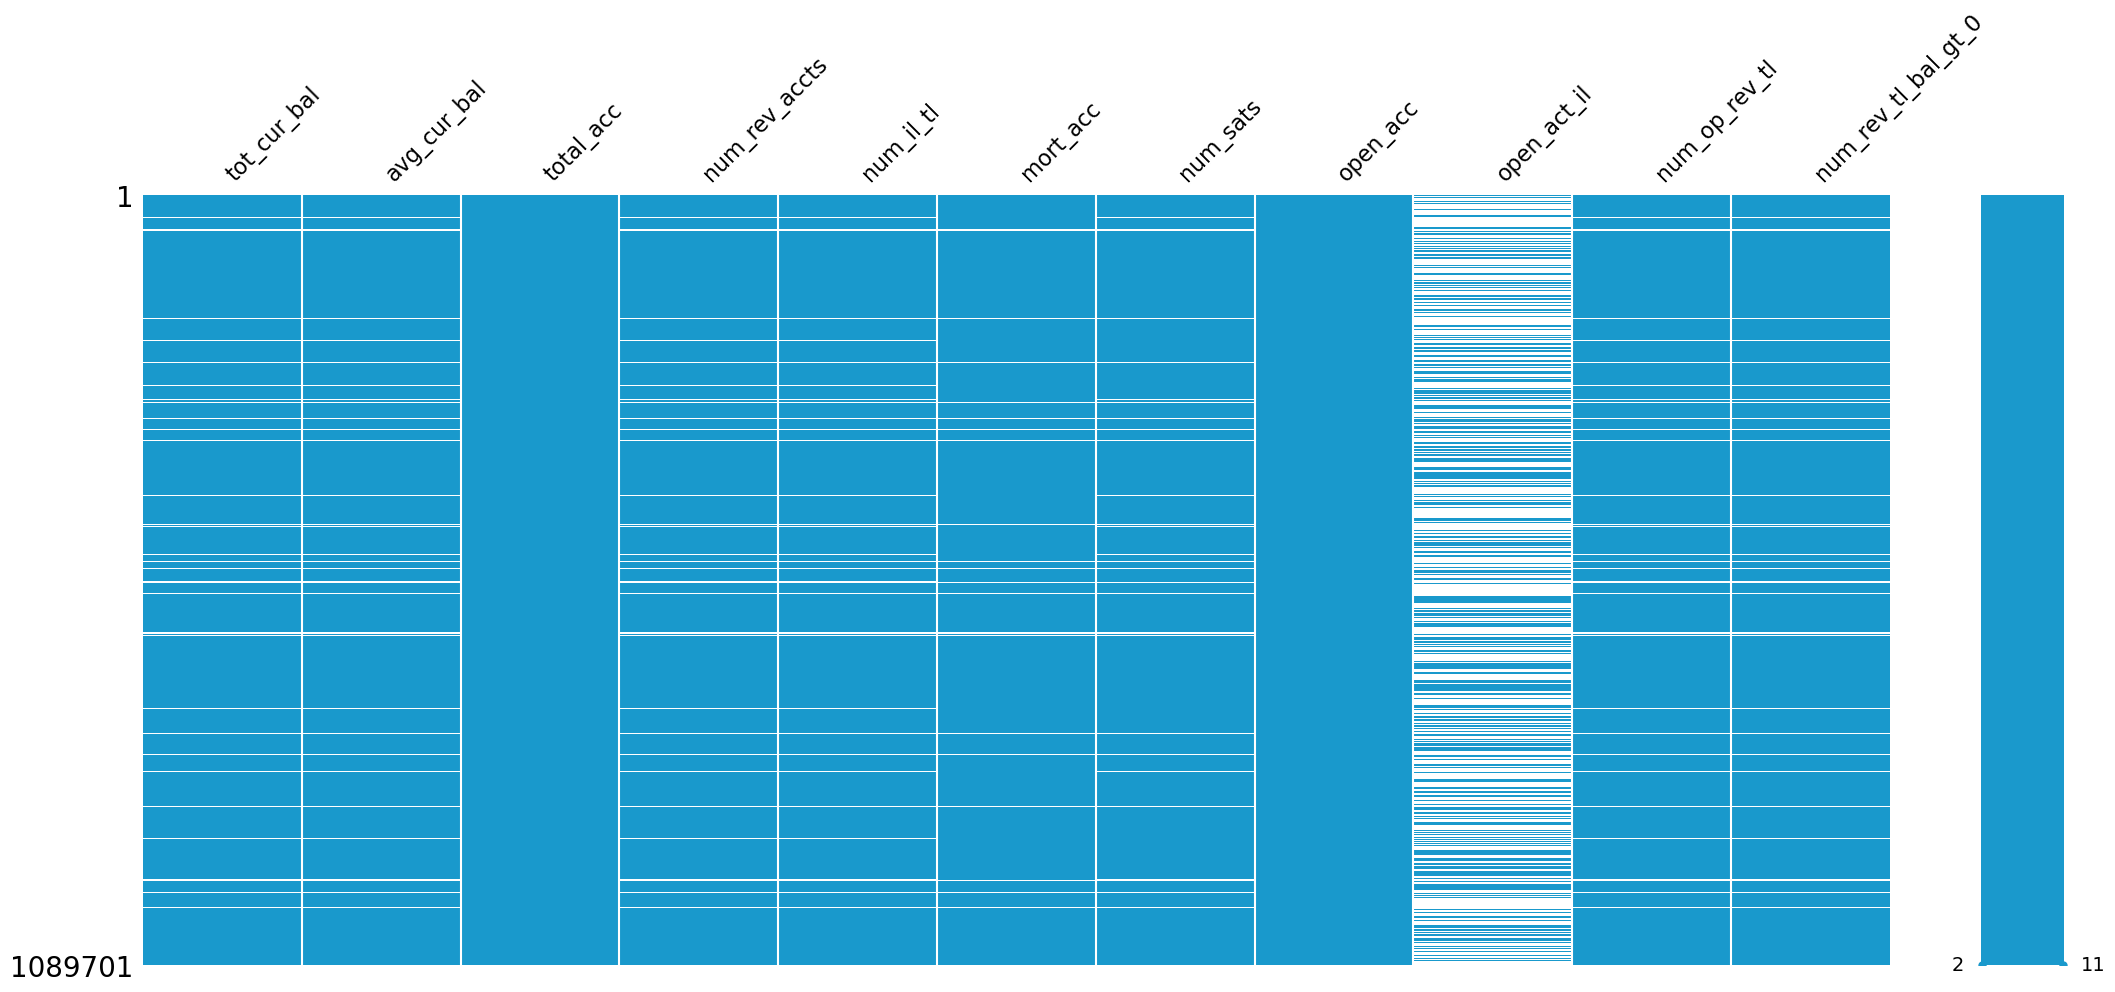

In [32]:
msno.matrix(df=avg_df.iloc[:, :], color=(0.1, 0.6, 0.8));

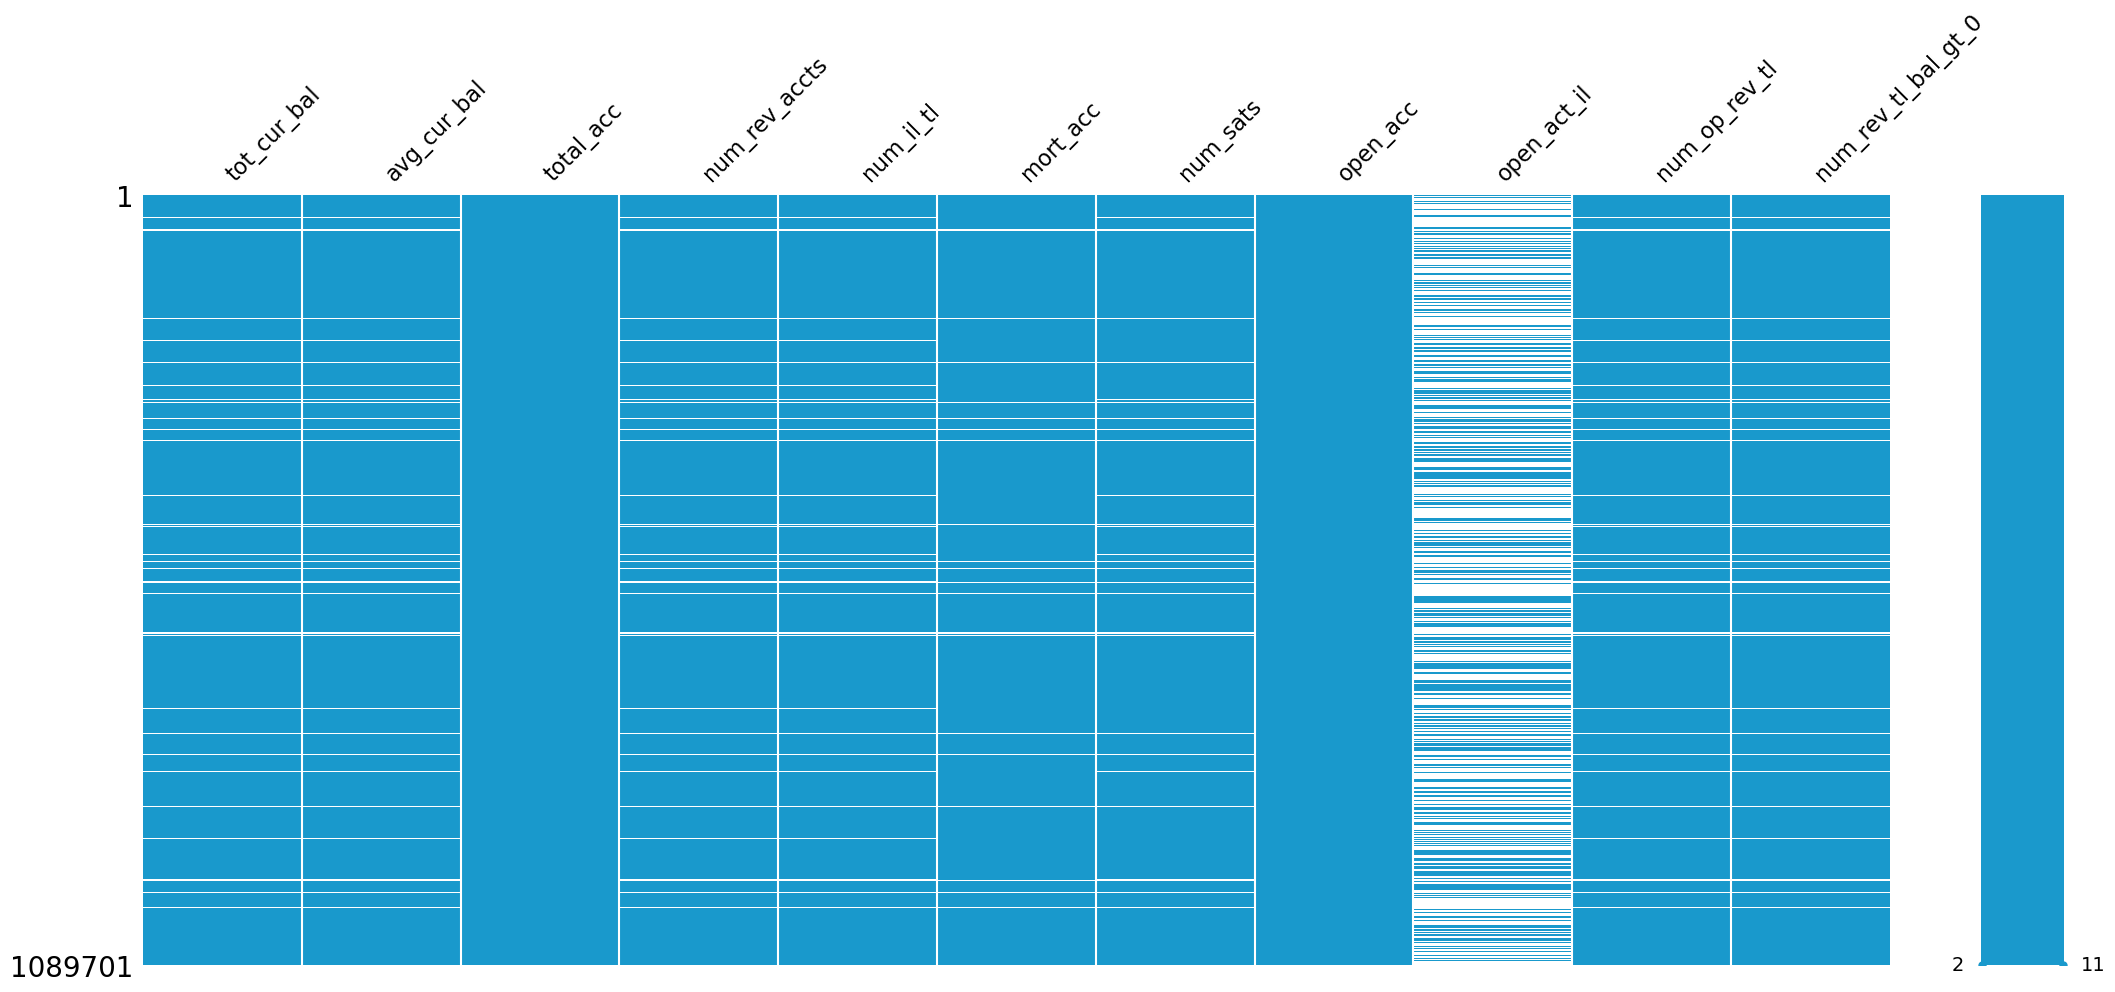

In [33]:
#total_acc와 open_
msno.matrix(df=avg_df, color=(0.1, 0.6, 0.8));

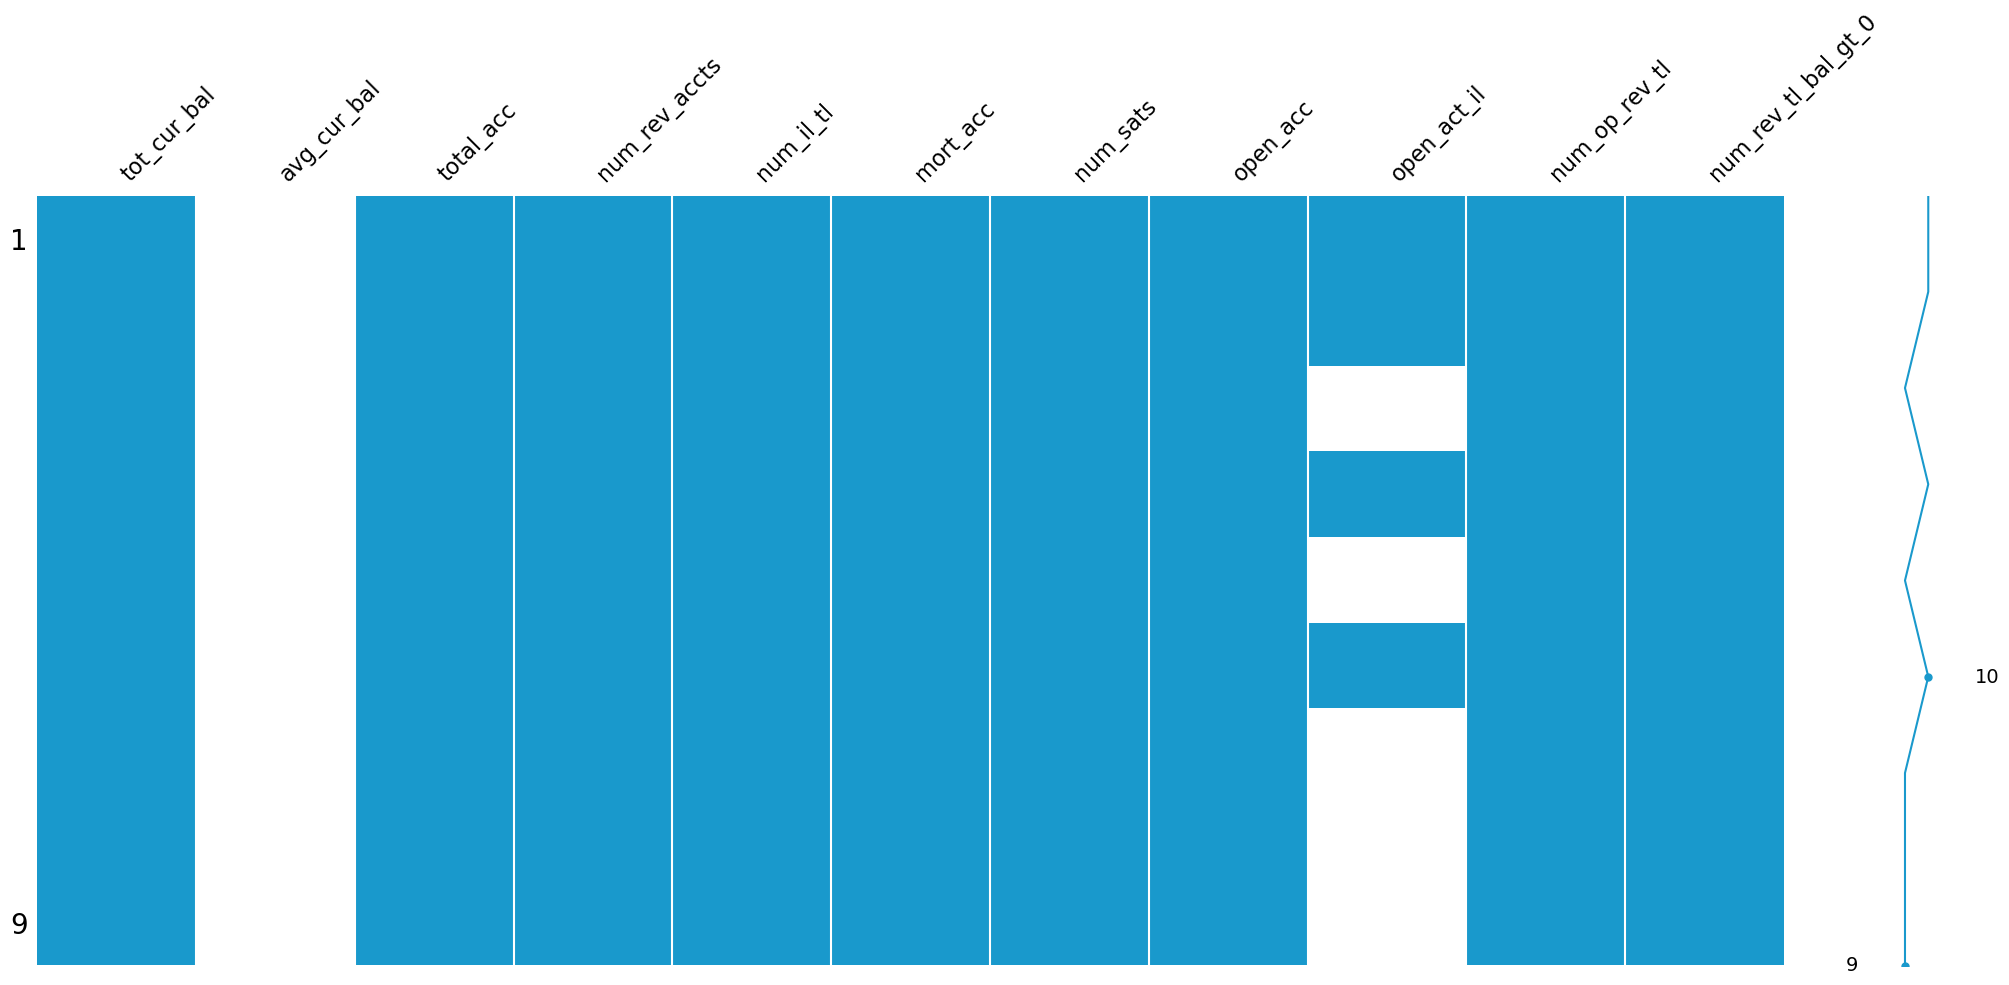

In [34]:
#결측치 없는 open_acc와 다른 결측치 관계 파악
#open_acc == 0이면 avg_cur_bal는 전부 결측치 
msno.matrix(df=avg_df.loc[(avg_df['open_acc']==0) ,:], color=(0.1, 0.6, 0.8));

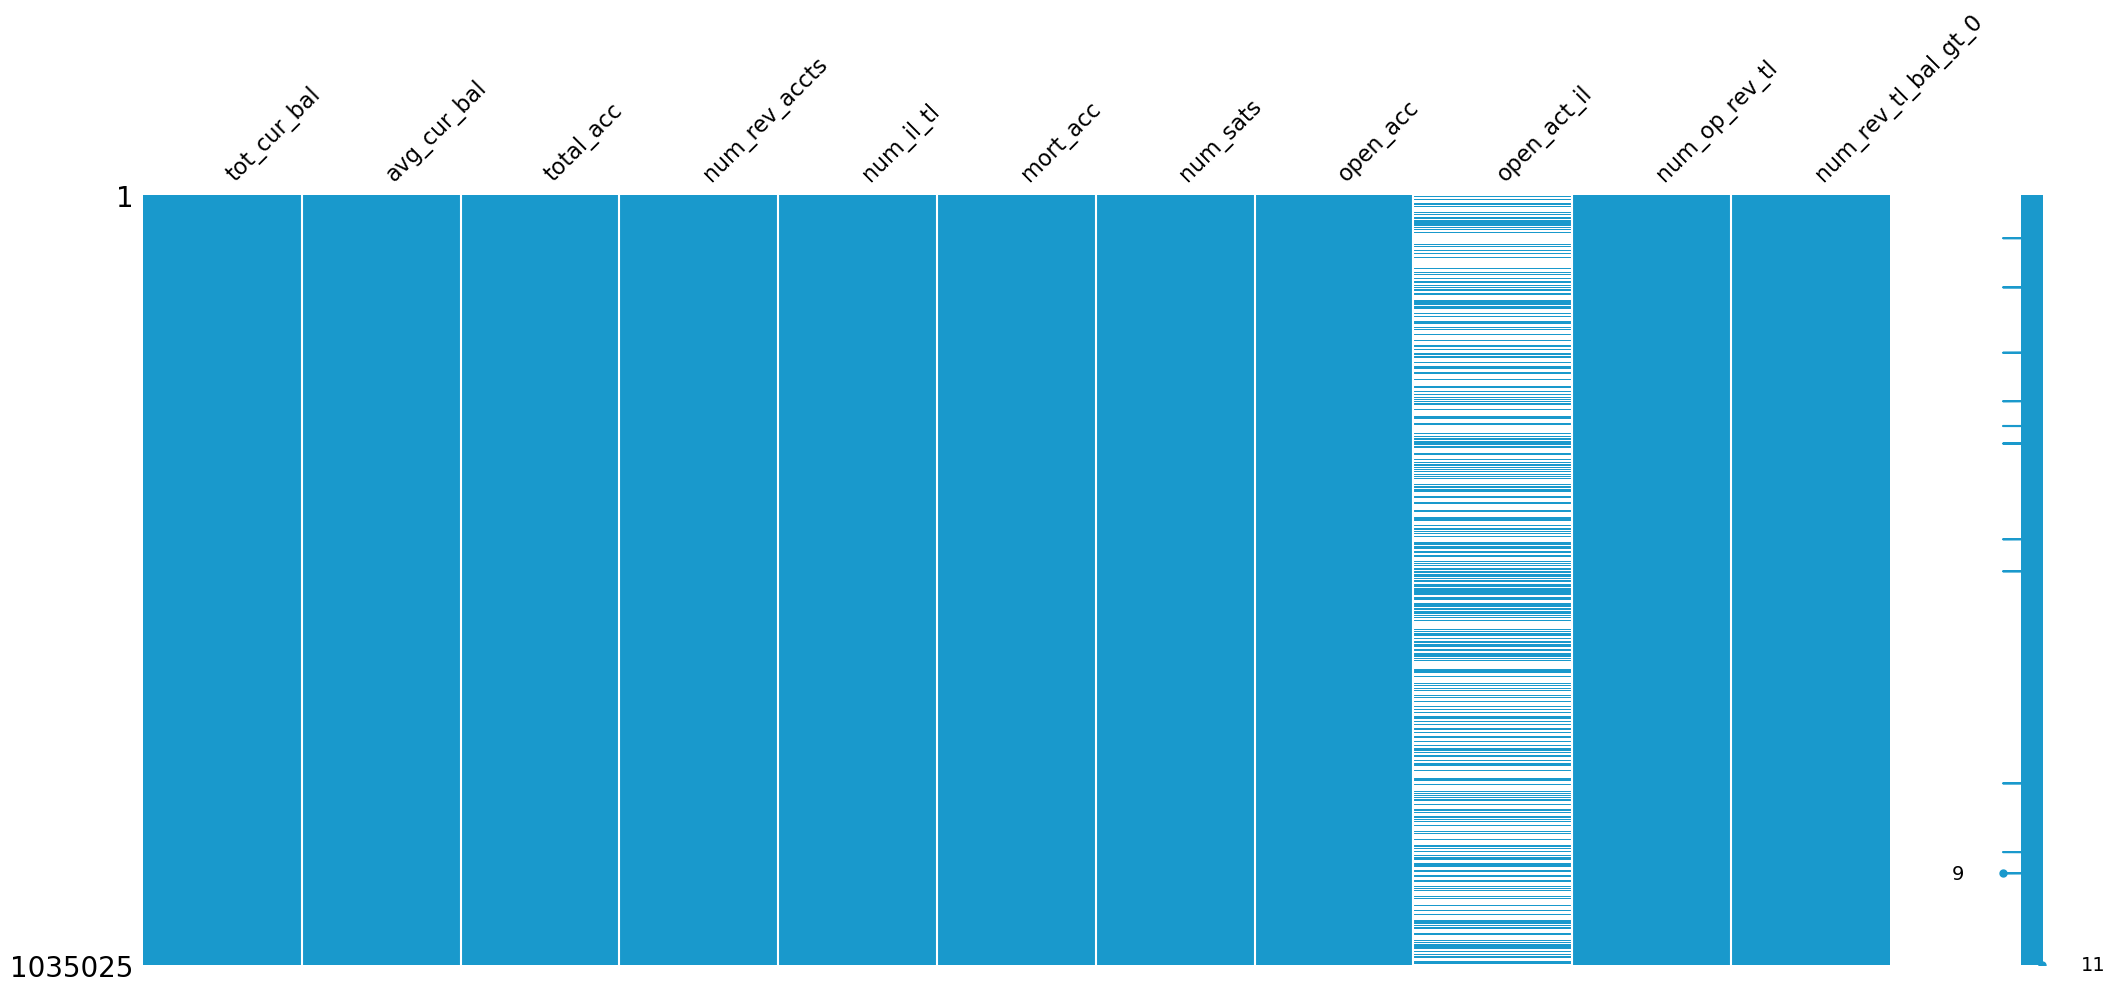

In [35]:
#tot_cur_bal가 결측 없으면 avg_cur_bal도 없음

msno.matrix(df=avg_df.loc[(avg_df['tot_cur_bal'].isna()==False) ,:], color=(0.1, 0.6, 0.8));

In [36]:
avg_df.loc[ (avg_df['tot_cur_bal']==0),:]

,tot_cur_bal,avg_cur_bal,total_acc,num_rev_accts,num_il_tl,mort_acc,num_sats,open_acc,open_act_il,num_op_rev_tl,num_rev_tl_bal_gt_0
422126,0.0,0.0,4.0,3.0,1.0,0.0,3.0,3.0,0.0,3.0,0.0
727436,0.0,0.0,7.0,7.0,0.0,0.0,4.0,4.0,NaN,4.0,0.0
71246,0.0,0.0,6.0,5.0,1.0,0.0,5.0,5.0,NaN,5.0,0.0
1277977,0.0,0.0,4.0,3.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0
917828,0.0,NaN,10.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
395049,0.0,0.0,3.0,3.0,0.0,0.0,3.0,3.0,0.0,3.0,0.0
389279,0.0,0.0,5.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
514258,0.0,0.0,11.0,11.0,0.0,0.0,9.0,9.0,0.0,9.0,0.0
889038,0.0,0.0,18.0,13.0,2.0,2.0,6.0,6.0,NaN,5.0,0.0


In [37]:
#1차 결측치 대체 : 논리적 결측 
avg_df = avg_df.copy()
avg_df.loc[(avg_df['num_sats'] == 0) | (avg_df['tot_cur_bal'] == 0), 'avg_cur_bal'] = 0
avg_df['avg_cur_bal'].isna().sum()  #54693에서 20개 정도 대체됨

54676

In [38]:
#잔액 관련
credit_balance = ['tot_cur_bal', 'avg_cur_bal','avg_cur_bal',
                  'all_util','bc_open_to_buy','max_bal_bc',
                  'tot_hi_cred_lim','total_bc_limit', #한도
                  'total_pymnt_inv','total_pymnt','total_rec_prncp','total_rec_int',
                  'total_bal_ex_mort','total_bal_il','revol_bal'] 
tot_df = EDA[credit_balance]
tot_df[tot_df['tot_cur_bal'].isna()].sample(20)

,tot_cur_bal,avg_cur_bal,avg_cur_bal,all_util,bc_open_to_buy,max_bal_bc,tot_hi_cred_lim,total_bc_limit,total_pymnt_inv,total_pymnt,total_rec_prncp,total_rec_int,total_bal_ex_mort,total_bal_il,revol_bal
934896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5744.17,5744.173068,5000.00,744.17,NaN,NaN,11466.0
1191047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12466.74,12515.550000,4961.13,6280.02,NaN,NaN,24081.0
940754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13480.95,13507.332259,12800.00,707.33,NaN,NaN,45637.0
922245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7057.33,7057.334603,6500.00,557.33,NaN,NaN,14525.0
936906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5631.71,5631.711937,5000.00,631.71,NaN,NaN,5942.0
940435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21845.16,21927.387973,20000.00,1927.39,NaN,NaN,9552.0
1190029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33496.42,33834.769984,27500.00,6334.77,NaN,NaN,15820.0
1191313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13472.97,13472.970006,11200.00,2272.97,NaN,NaN,13023.0
941852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6406.21,6439.749995,4800.00,1639.75,NaN,NaN,3565.0
1183587,NaN,NaN,NaN,NaN,4931.0,NaN,NaN,19600.0,16882.45,16882.454886,15000.00,1882.45,17805.0,NaN,14669.0


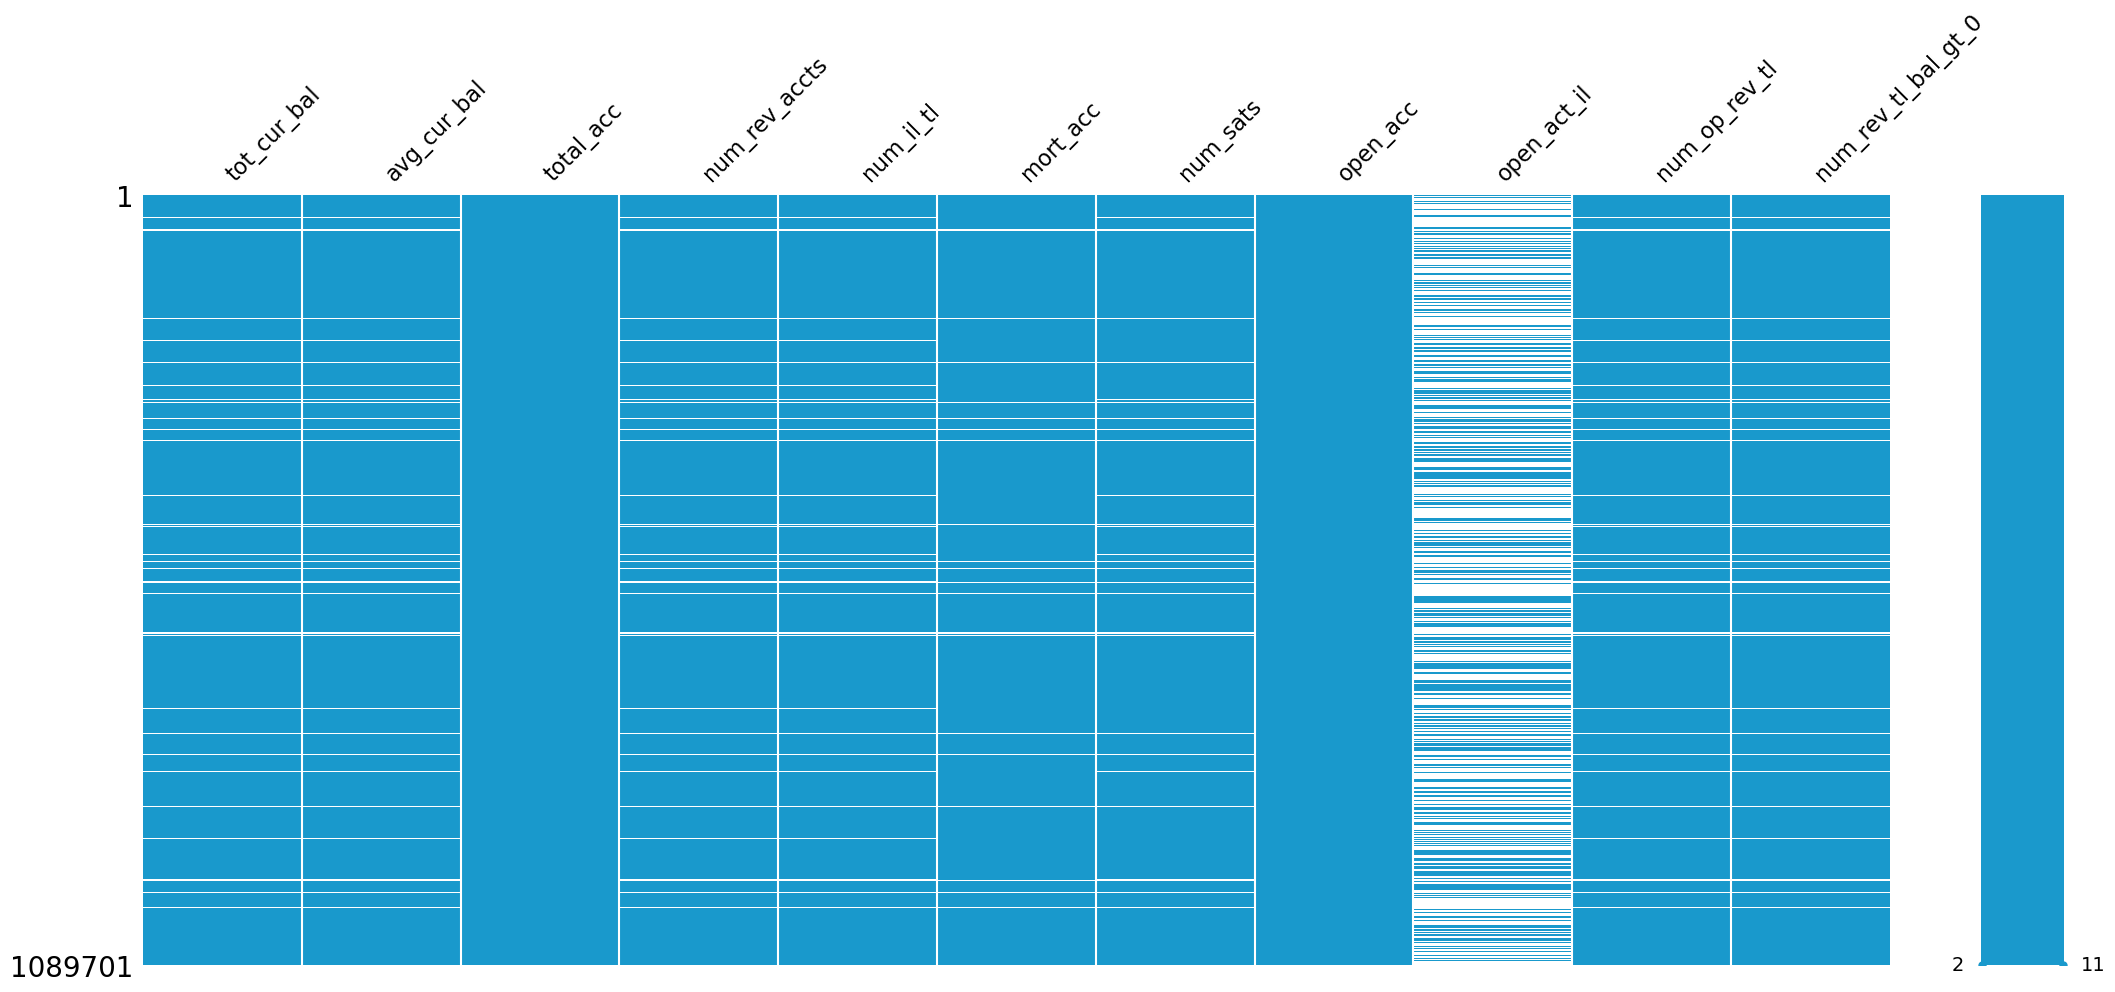

In [39]:
msno.matrix(df=avg_df, color=(0.1, 0.6, 0.8));

### 'avg_cur_bal'는 어떻게 계산되나

In [40]:
avg_df.shape

(1089701, 11)

In [41]:
# 1. 'avg_cur_bal X num_sats' 평균 잔액 * 만족스런 계좌 수 = 전체 잔액
# 오차 범위 10달러 설정
avg_df.loc[:, 'avg_cur_bal X num_sats'] = avg_df['num_sats'] * avg_df['avg_cur_bal']
avg_df[
    (avg_df['avg_cur_bal'] * avg_df['num_sats'] >= avg_df['tot_cur_bal'] - 10) & 
    (avg_df['avg_cur_bal'] * avg_df['num_sats'] <= avg_df['tot_cur_bal'] + 10)
]

,tot_cur_bal,avg_cur_bal,total_acc,num_rev_accts,num_il_tl,mort_acc,num_sats,open_acc,open_act_il,num_op_rev_tl,num_rev_tl_bal_gt_0,avg_cur_bal X num_sats
530674,180593.0,12040.0,21.0,15.0,1.0,5.0,15.0,15.0,1.0,13.0,8.0,180600.0
465057,131188.0,14576.0,38.0,4.0,34.0,0.0,9.0,9.0,5.0,4.0,1.0,131184.0
148918,76482.0,5099.0,22.0,12.0,10.0,0.0,15.0,15.0,NaN,11.0,9.0,76485.0
343684,21526.0,3588.0,8.0,6.0,2.0,0.0,6.0,6.0,NaN,4.0,3.0,21528.0
290496,223337.0,22334.0,26.0,14.0,5.0,7.0,10.0,10.0,NaN,8.0,6.0,223340.0
...,...,...,...,...,...,...,...,...,...,...,...,...
109985,252827.0,15802.0,37.0,30.0,3.0,3.0,16.0,16.0,NaN,15.0,11.0,252832.0
673511,55593.0,3706.0,25.0,21.0,3.0,0.0,15.0,15.0,NaN,12.0,10.0,55590.0
509553,511425.0,31964.0,29.0,11.0,14.0,4.0,16.0,16.0,5.0,9.0,8.0,511424.0
107784,248407.0,15525.0,30.0,17.0,12.0,1.0,16.0,16.0,NaN,11.0,8.0,248400.0


In [42]:
# 2. 'avg_cur_bal X open_acc' 평균 잔액 * 활성계좌 수 = 전체 잔액
# 오차 범위 10달러 설정

avg_df.loc[:, 'avg_cur_bal X open_acc'] = avg_df['open_acc'] * avg_df['avg_cur_bal']
avg_df[
    (avg_df['avg_cur_bal X open_acc'] >= avg_df['tot_cur_bal'] - 10) & 
    (avg_df['avg_cur_bal X open_acc'] <= avg_df['tot_cur_bal'] + 10)
]

,tot_cur_bal,avg_cur_bal,total_acc,num_rev_accts,num_il_tl,mort_acc,num_sats,open_acc,open_act_il,num_op_rev_tl,num_rev_tl_bal_gt_0,avg_cur_bal X num_sats,avg_cur_bal X open_acc
530674,180593.0,12040.0,21.0,15.0,1.0,5.0,15.0,15.0,1.0,13.0,8.0,180600.0,180600.0
465057,131188.0,14576.0,38.0,4.0,34.0,0.0,9.0,9.0,5.0,4.0,1.0,131184.0,131184.0
148918,76482.0,5099.0,22.0,12.0,10.0,0.0,15.0,15.0,NaN,11.0,9.0,76485.0,76485.0
31145,486746.0,54083.0,18.0,12.0,3.0,3.0,8.0,9.0,NaN,7.0,5.0,432664.0,486747.0
343684,21526.0,3588.0,8.0,6.0,2.0,0.0,6.0,6.0,NaN,4.0,3.0,21528.0,21528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109985,252827.0,15802.0,37.0,30.0,3.0,3.0,16.0,16.0,NaN,15.0,11.0,252832.0,252832.0
673511,55593.0,3706.0,25.0,21.0,3.0,0.0,15.0,15.0,NaN,12.0,10.0,55590.0,55590.0
509553,511425.0,31964.0,29.0,11.0,14.0,4.0,16.0,16.0,5.0,9.0,8.0,511424.0,511424.0
107784,248407.0,15525.0,30.0,17.0,12.0,1.0,16.0,16.0,NaN,11.0,8.0,248400.0,248400.0


In [43]:
# 3. 'avg_cur_bal X total_acc' 평균 잔액 * 활성계좌 수 = 전체 잔액
# 오차 범위 10달러 설정


avg_df.loc[:, 'avg_cur_bal X total_acc'] = avg_df['total_acc'] * avg_df['avg_cur_bal']
avg_df[
    (avg_df['avg_cur_bal X total_acc'] >= avg_df['tot_cur_bal'] - 10) & 
    (avg_df['avg_cur_bal X total_acc'] <= avg_df['tot_cur_bal'] + 10)
]

,tot_cur_bal,avg_cur_bal,total_acc,num_rev_accts,num_il_tl,mort_acc,num_sats,open_acc,open_act_il,num_op_rev_tl,num_rev_tl_bal_gt_0,avg_cur_bal X num_sats,avg_cur_bal X open_acc,avg_cur_bal X total_acc
496496,15733.0,2622.0,6.0,4.0,2.0,0.0,6.0,6.0,2.0,4.0,4.0,15732.0,15732.0,15732.0
738458,8855.0,2214.0,4.0,3.0,1.0,0.0,4.0,4.0,NaN,3.0,3.0,8856.0,8856.0,8856.0
1221197,21204.0,2356.0,9.0,7.0,2.0,0.0,9.0,9.0,2.0,7.0,5.0,21204.0,21204.0,21204.0
817591,1962.0,392.0,5.0,5.0,0.0,0.0,5.0,5.0,NaN,5.0,3.0,1960.0,1960.0,1960.0
873138,10636.0,2127.0,5.0,4.0,1.0,0.0,5.0,5.0,NaN,4.0,4.0,10635.0,10635.0,10635.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363753,14362.0,2872.0,5.0,4.0,1.0,0.0,5.0,5.0,NaN,4.0,3.0,14360.0,14360.0,14360.0
1315270,16593.0,4148.0,4.0,3.0,1.0,0.0,4.0,4.0,1.0,3.0,3.0,16592.0,16592.0,16592.0
125320,18919.0,3784.0,5.0,4.0,1.0,0.0,5.0,5.0,NaN,4.0,4.0,18920.0,18920.0,18920.0
718362,24903.0,2767.0,9.0,7.0,2.0,0.0,9.0,9.0,NaN,7.0,6.0,24903.0,24903.0,24903.0


In [44]:
avg_df.isna().sum()

tot_cur_bal                 54676
avg_cur_bal                 54676
total_acc                       0
num_rev_accts               54677
num_il_tl                   54676
mort_acc                    38350
num_sats                    45270
open_acc                        0
open_act_il                654028
num_op_rev_tl               54676
num_rev_tl_bal_gt_0         54676
avg_cur_bal X num_sats      54676
avg_cur_bal X open_acc      54676
avg_cur_bal X total_acc     54676
dtype: int64

In [45]:
#일단 tot_cur_bal와 num_sats의 결측치가 해결되어야 계산할 수 있음.

In [46]:
avg_df[avg_df['tot_cur_bal'].isna()]

,tot_cur_bal,avg_cur_bal,total_acc,num_rev_accts,num_il_tl,mort_acc,num_sats,open_acc,open_act_il,num_op_rev_tl,num_rev_tl_bal_gt_0,avg_cur_bal X num_sats,avg_cur_bal X open_acc,avg_cur_bal X total_acc
933637,NaN,NaN,16.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
919918,NaN,NaN,38.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
1192171,NaN,NaN,14.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
953956,NaN,NaN,20.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
921754,NaN,NaN,18.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169824,NaN,NaN,37.0,NaN,NaN,0.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
928128,NaN,NaN,28.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
1186167,NaN,NaN,17.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
945648,NaN,NaN,10.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


tot_cur_bal    54676
dtype: int64

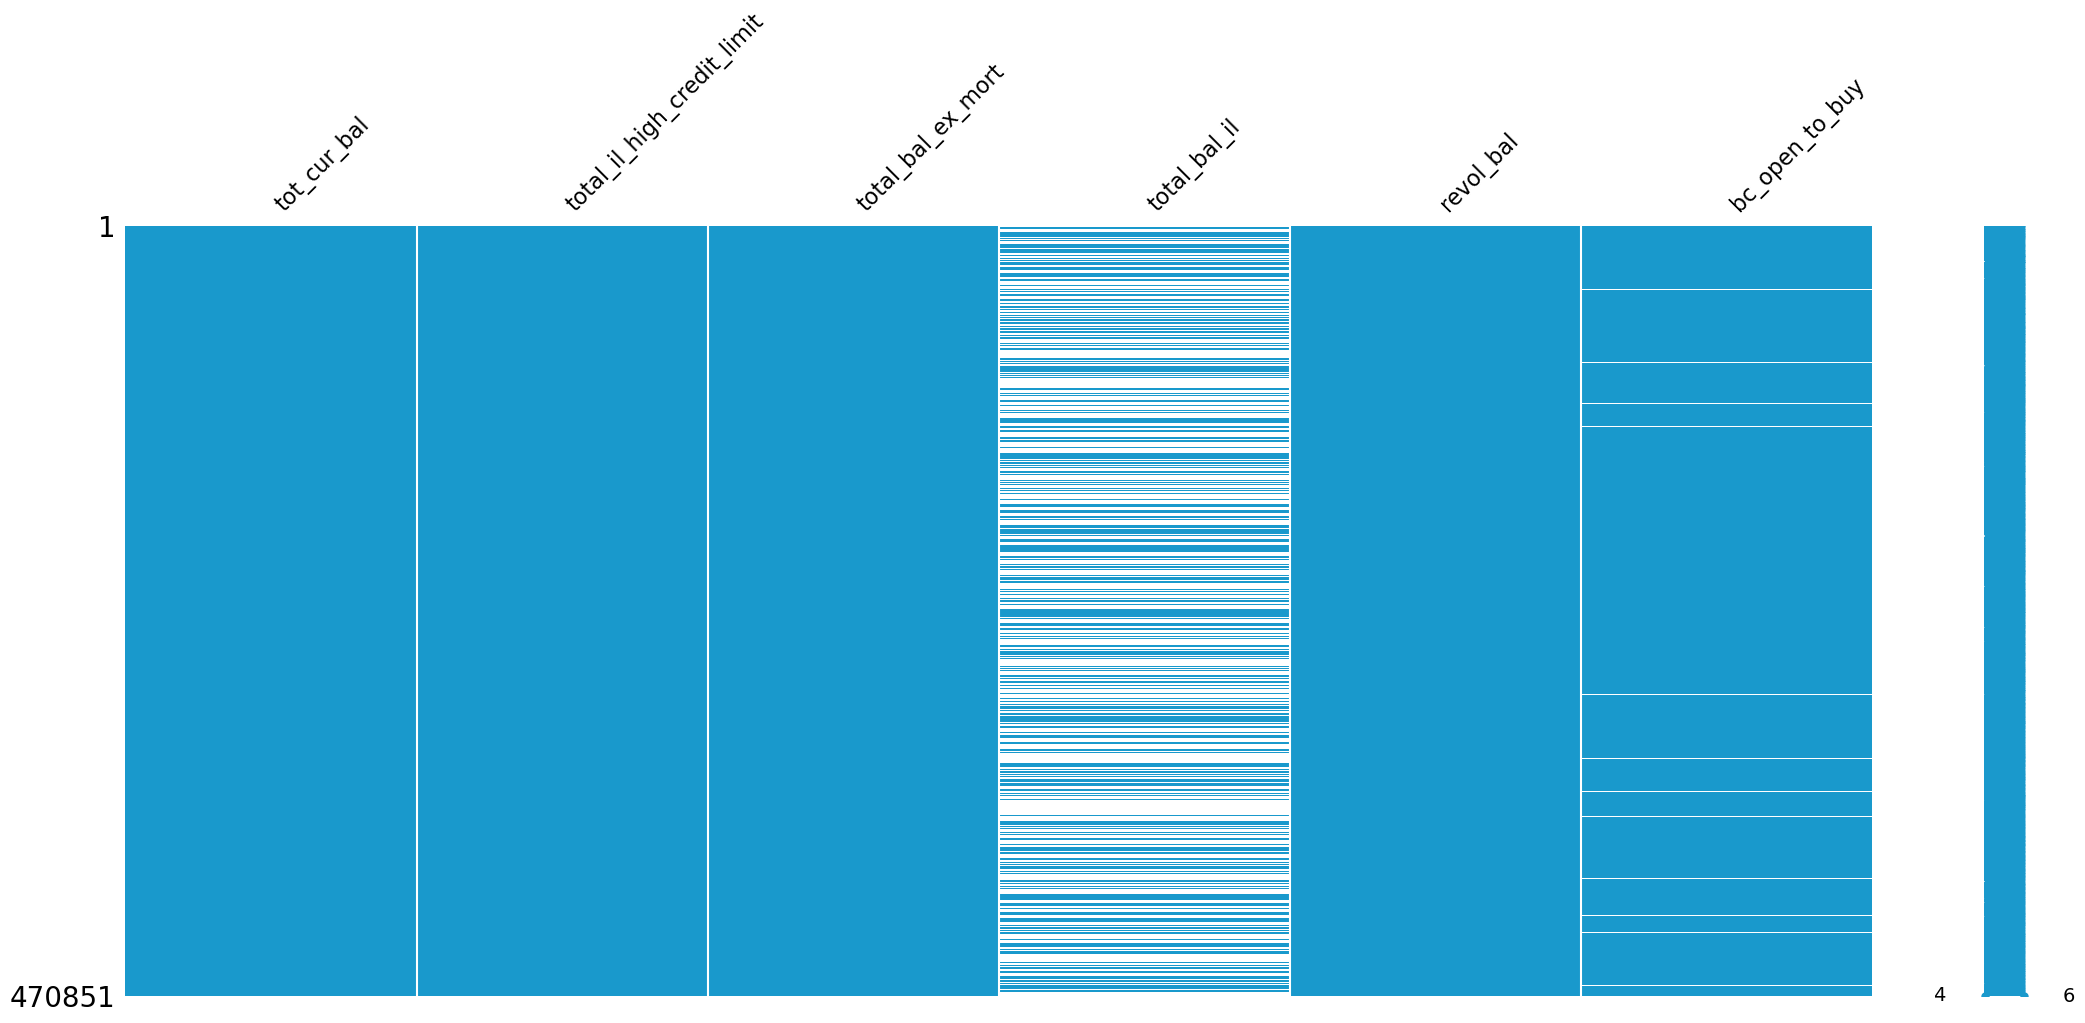

In [47]:
co2=EDA[['tot_cur_bal','total_il_high_credit_limit','total_bal_ex_mort','total_bal_il','revol_bal','bc_open_to_buy']][EDA['tot_cur_bal']>EDA['total_bal_ex_mort']]
msno.matrix(df=co2, color=(0.1, 0.6, 0.8));
EDA[['tot_cur_bal']].isna().sum()

In [48]:
EDA[['tot_cur_bal','total_bal_ex_mort','total_bal_il','revol_bal','bc_open_to_buy']]

,tot_cur_bal,total_bal_ex_mort,total_bal_il,revol_bal,bc_open_to_buy
1126992,18861.0,18861.0,NaN,18861.0,2245.0
530674,180593.0,26159.0,7436.0,18723.0,8899.0
465057,131188.0,131188.0,126565.0,4623.0,9377.0
148918,76482.0,76482.0,NaN,11011.0,12003.0
31145,486746.0,46069.0,NaN,37090.0,3351.0
...,...,...,...,...,...
1187260,NaN,NaN,NaN,3076.0,NaN
673511,55593.0,55593.0,NaN,16977.0,3507.0
509553,511425.0,207582.0,194309.0,13273.0,19960.0
107784,248407.0,81765.0,NaN,20946.0,18036.0


In [49]:
# 'verification_status' 변수의 범주 그룹별 'avg_cur_bal'의 결측치 개수 확인
missing_counts_by_verification_status = EDA.groupby('verification_status')['avg_cur_bal'].apply(lambda x: x.isnull().sum())

# 결과 출력
print(missing_counts_by_verification_status)

verification_status
Not Verified       21890
Source Verified    14179
Verified           18624
Name: avg_cur_bal, dtype: int64


In [50]:
EDA['grade'].value_counts()

grade
B    318541
C    308910
A    189985
D    162854
E     76035
F     25949
G      7427
Name: count, dtype: int64

In [51]:
# 특정 변수(예: 'target_variable')에 대한 결측치가 있는 행만 선택
missing_rows = EDA[EDA['avg_cur_bal'].isnull()]
print(missing_rows['verification_status'].value_counts(),'\n')
print(missing_rows['grade'].value_counts(),'\n')
print(missing_rows['debt_settlement_flag'].value_counts(),'\n')

verification_status
Not Verified       21890
Verified           18624
Source Verified    14179
Name: count, dtype: int64 

grade
B    17439
A    13483
C    11229
D     7162
E     3606
F     1384
G      390
Name: count, dtype: int64 

debt_settlement_flag
N    54424
Y      269
Name: count, dtype: int64 



In [52]:
not_missing_rows = EDA[EDA['avg_cur_bal'].isnull()==False]
not_missing_rows 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status,collection_recovery_fee_flag
1126992,3359931,NaN,12000.0,12000.0,12000.0,36 months,14.33,412.06,C,C1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n
530674,110061292,NaN,20300.0,20300.0,20300.0,60 months,15.05,483.47,C,C4,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n
465057,78729404,NaN,13600.0,13600.0,13600.0,60 months,18.25,347.21,D,D3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n
148918,58390724,NaN,8000.0,8000.0,8000.0,36 months,7.89,250.29,A,A5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off,y
31145,66230653,NaN,24000.0,24000.0,24000.0,36 months,9.17,765.10,B,B2,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109985,60545696,NaN,24000.0,24000.0,24000.0,36 months,7.89,750.86,A,A5,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n
673511,37830327,NaN,25000.0,25000.0,25000.0,60 months,19.99,662.21,E,E3,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off,y
509553,136921611,NaN,10000.0,10000.0,10000.0,36 months,13.56,339.65,C,C1,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n
107784,61309336,NaN,25000.0,25000.0,25000.0,36 months,6.24,763.28,A,A2,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid,n


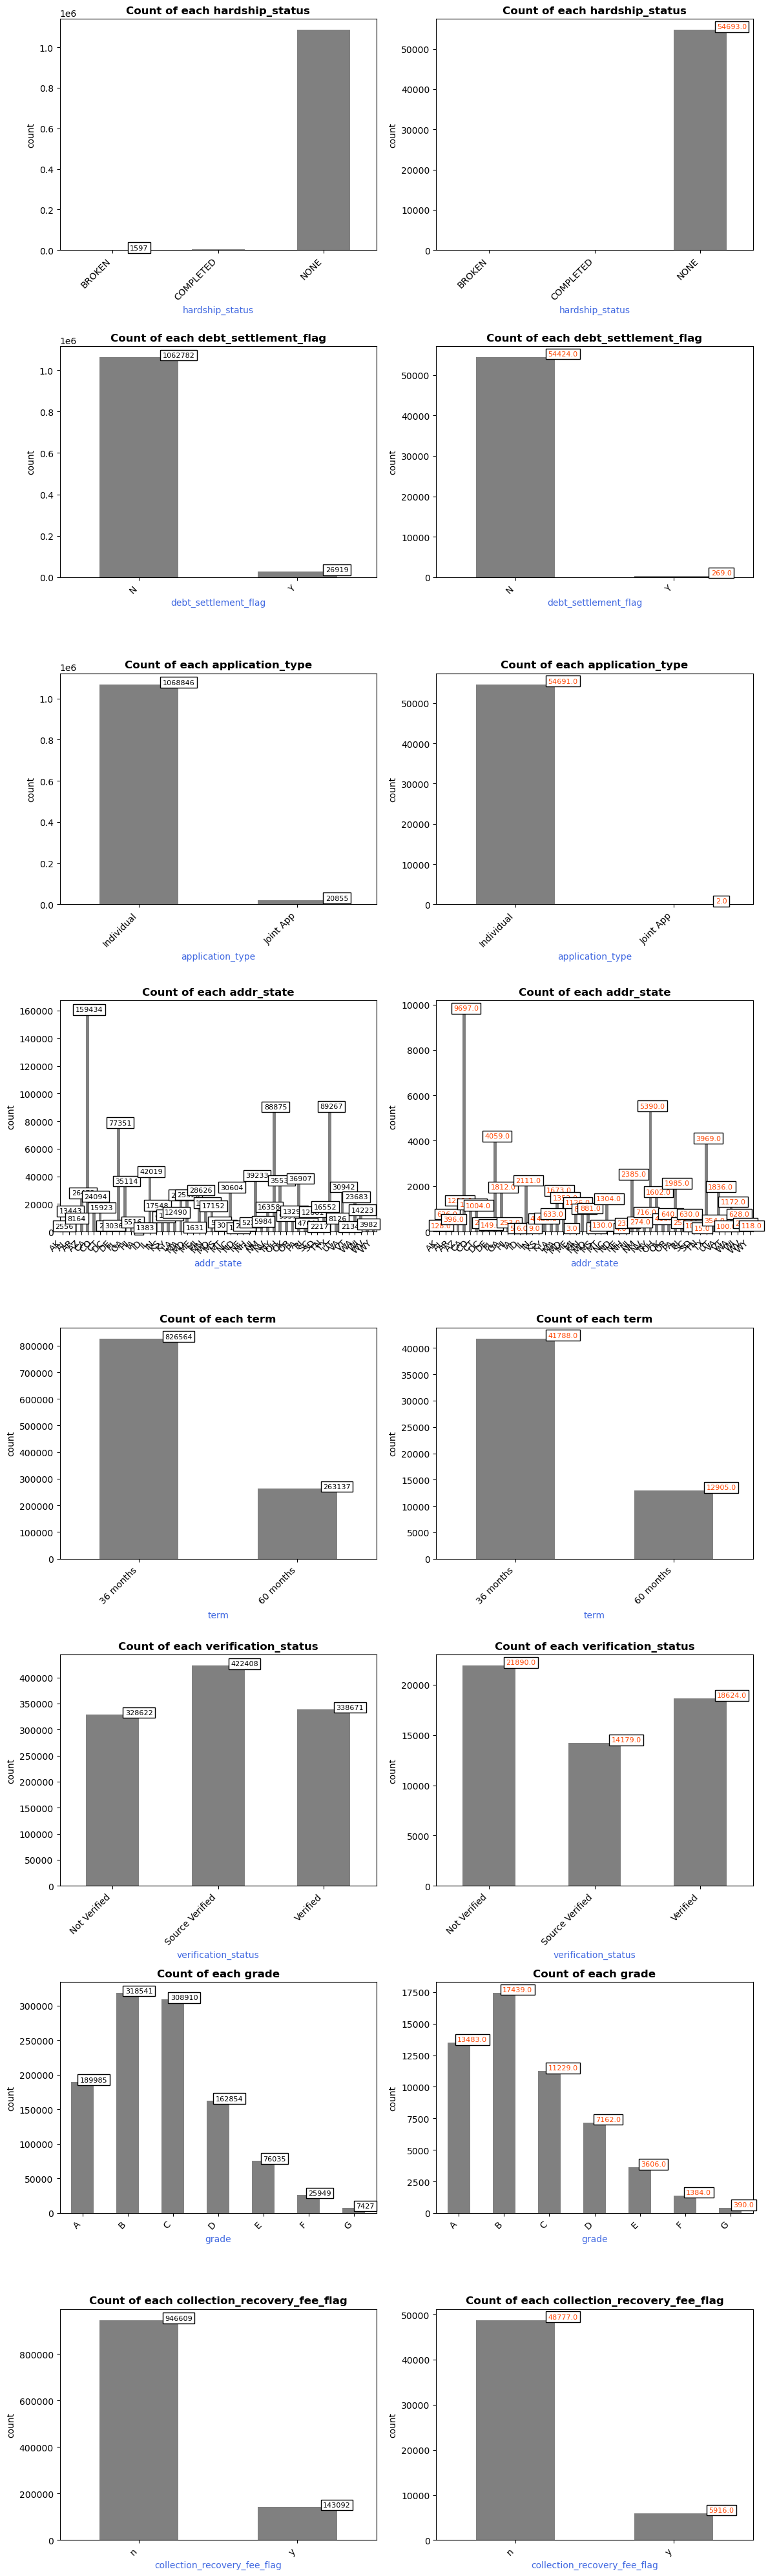

In [53]:
fig, ax = plt.subplots(len(cat_feature), 2, figsize=(12, 5*len(cat_feature)))
for idx, col in enumerate(cat_feature):
    ax1 = sns.countplot(data=EDA[cat_feature + [target]], x=col, order=np.sort(EDA[col].dropna().unique()), 
                        width=0.5, ax=ax[idx, 0], color='gray')
    ax1.set_title(f"Count of each {col}",size=12, weight="bold")
    font1 = {'color':'royalblue','size':10, 'rotation':360}
    ax1.set_xlabel(col, fontdict=font1)

    # 타겟에 대한 컬럼의 범주별 비율 계산
    ax2 = sns.countplot(data=missing_rows[cat_feature + [target]], x=col, order=np.sort(EDA[col].dropna().unique()), 
                        width=0.5, ax=ax[idx, 1], color='gray')
    ax2.set_title(f"Count of each {col}",size=12, weight="bold")
    font1 = {'color':'royalblue','size':10, 'rotation':360}
    ax2.set_xlabel(col, fontdict=font1)


    for bar1, bar2 in zip(ax1.patches, ax2.patches):
        bbox_props = dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white")  # 네모 박스 스타일 정의
        ax1.text(bar1.get_x() + bar1.get_width(), bar1.get_height(), int(bar1.get_height()), 
                 ha="center", size=8,bbox=bbox_props)
        ax2.text(bar2.get_x() + bar2.get_width()+0.05 , bar2.get_height(), f'{bar2.get_height()}',
                 ha='center', va='bottom', size=8, color='orangered',bbox=bbox_props)
        


# 눈금 레이블 회전 설정
set_xticklabels(ax[:, 0])
set_xticklabels(ax[:, 1])

# xticks 크기 조정
plt.xticks(fontsize=10)


plt.tight_layout()
plt.show()

- avg_cur_bal에 na 값이 있는 데이터프레임에서 범주 분포 비율에 영향을 받은 변수는 verification_status (소득검증여부)


In [54]:
EDA[EDA['last_fico_range_low']<600]['avg_cur_bal'].isna().sum()

8679

In [55]:

score = ['fico_range_high', 'fico_range_low', 'last_fico_range_high', 'last_fico_range_low',
         'tot_hi_cred_lim','total_il_high_credit_limit','total_rev_hi_lim','total_bc_limit','mths_since_last_major_derog']
avg = EDA[score+['avg_cur_bal']]

### 3-4.open_rv_24m, open_il_24m	결측치 탐색: 전체의 60.02% 결측

1. 결측값이 5% 정도인 두개의 합 의미의 컬럼 'acc_open_past_24mths'으로 사용
2. 'acc_open_past_24mths'두개를 분할..

- accts

In [56]:
from prettytable import PrettyTable
acc_mths = ['acc_open_past_24mths', 'open_rv_24m','open_il_24m','num_tl_op_past_12m', 'open_rv_12m', 'open_il_12m']
table = PrettyTable()
table.field_names = ["변수명", "결측치 개수", "전체 비율"]

for col in acc_mths:
    na_cnt = EDA[col].isna().sum()
    total_rows = EDA.shape[0]
    ratio = (na_cnt / total_rows) * 100
    if na_cnt != 0:
        table.add_row([col, na_cnt, f'{ratio:.2f}%'])
table

변수명,결측치 개수,전체 비율
acc_open_past_24mths,38350,3.52%
open_rv_24m,654028,60.02%
open_il_24m,654028,60.02%
num_tl_op_past_12m,54676,5.02%
open_rv_12m,654028,60.02%
open_il_12m,654028,60.02%


In [57]:
g3 =['acc_open_past_24mths', 'open_rv_24m','open_il_24m',
     'mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op','mths_since_rcnt_il']

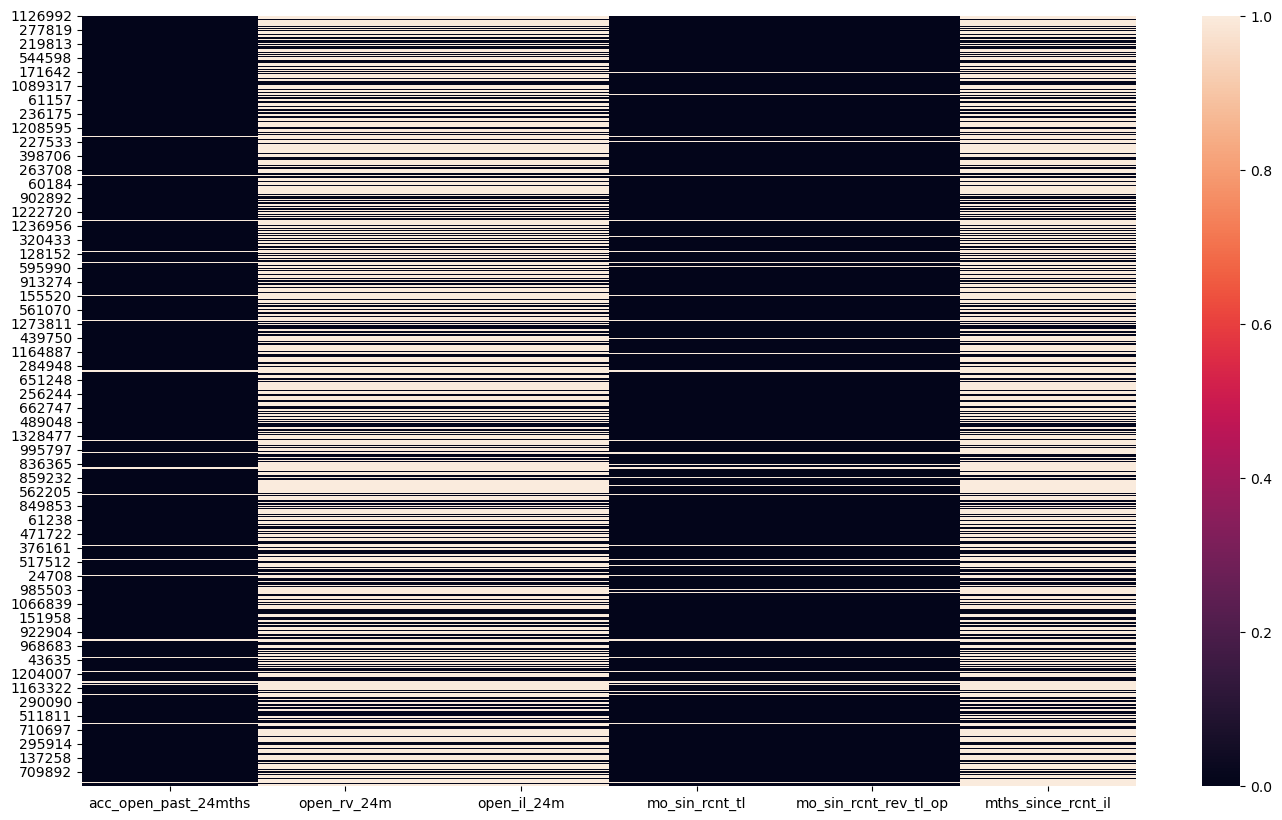

In [58]:
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(EDA[g3].isna(), ax=ax)
plt.show()

> 비슷한 카테고리의 변수 12m와도 같은 결측치 위치 패턴이 보임

In [59]:
acct = ['open_acc_6m', 'acc_open_past_24mths', 'open_rv_24m', 'open_il_24m', 
        'num_tl_op_past_12m', 'open_rv_12m', 'open_il_12m', 
        'total_acc',  'num_rev_accts', 'num_il_tl', 'mort_acc', 
         'open_acc', 'open_act_il', 'num_op_rev_tl']

In [60]:
EDA[acct].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1089701 entries, 1126992 to 162341
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   open_acc_6m           435673 non-null   float64
 1   acc_open_past_24mths  1051351 non-null  float64
 2   open_rv_24m           435673 non-null   float64
 3   open_il_24m           435673 non-null   float64
 4   num_tl_op_past_12m    1035025 non-null  float64
 5   open_rv_12m           435673 non-null   float64
 6   open_il_12m           435673 non-null   float64
 7   total_acc             1089701 non-null  float64
 8   num_rev_accts         1035024 non-null  float64
 9   num_il_tl             1035025 non-null  float64
 10  mort_acc              1051351 non-null  float64
 11  open_acc              1089701 non-null  float64
 12  open_act_il           435673 non-null   float64
 13  num_op_rev_tl         1035025 non-null  float64
dtypes: float64(14)
memory usage: 124.7

#### **변수간 관계 정리**
- 'acc_open_past_24mths'= 'open_rv_24m'+'open_il_24m' : **24월 이내 계좌 개설 개수**
  
- 'total_acc' = 'num_il_tl' + 'num_op_rev_tl' + 'mort_acc' + 기타 계좌  : **총 계좌 개설 개수**

- 'mo_sin_rcnt_tl'  : **가장 최근 계정 개설 이후 경과한 개월 수**
  
- 'mo_sin_rcnt_rev_tl_op' : **가장 최근 리볼빙 계정 개설 이후 경과한 개월 수**

- mths_since_rcnt_il : **가장 최근 할부 계정 개설 이후 경과한 개월 수**

In [61]:
EDA[['acc_open_past_24mths', 'open_rv_24m','open_il_24m',
     'total_acc', 'num_il_tl', 'num_op_rev_tl','mort_acc','num_bc_tl','num_actv_bc_tl','num_actv_rev_tl',
     'mo_sin_rcnt_tl','mths_since_rcnt_il','mo_sin_rcnt_rev_tl_op']].sample(5)


,acc_open_past_24mths,open_rv_24m,open_il_24m,total_acc,num_il_tl,num_op_rev_tl,mort_acc,num_bc_tl,num_actv_bc_tl,num_actv_rev_tl,mo_sin_rcnt_tl,mths_since_rcnt_il,mo_sin_rcnt_rev_tl_op
188177,4.0,NaN,NaN,12.0,8.0,4.0,0.0,1.0,1.0,4.0,13.0,NaN,13.0
461615,4.0,3.0,1.0,35.0,12.0,10.0,0.0,13.0,4.0,5.0,3.0,7.0,3.0
999411,4.0,3.0,1.0,16.0,6.0,7.0,1.0,5.0,1.0,1.0,7.0,11.0,7.0
61894,0.0,NaN,NaN,16.0,7.0,5.0,0.0,4.0,2.0,3.0,28.0,NaN,28.0
1303348,3.0,2.0,1.0,9.0,1.0,7.0,0.0,6.0,4.0,6.0,1.0,24.0,1.0


In [62]:
EDA[['acc_open_past_24mths', 'open_rv_24m','open_il_24m',
     'mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op','mths_since_rcnt_il']].isna().sum()

acc_open_past_24mths      38350
open_rv_24m              654028
open_il_24m              654028
mo_sin_rcnt_tl            54676
mo_sin_rcnt_rev_tl_op     54676
mths_since_rcnt_il       665609
dtype: int64

In [63]:
g3= ['acc_open_past_24mths', 'open_rv_24m','open_il_24m',
     'mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op','mths_since_rcnt_il']

**rev개설 경과개월수 24인 것 -> open_rv_24m == 0인 것이 논리적(데이터의 시점이 같다고 보았을 때)**

In [64]:
EDA['mo_sin_rcnt_rev_tl_op'].isna().sum()

54676

In [65]:
EDA[g3][EDA['mo_sin_rcnt_rev_tl_op']>24]

,acc_open_past_24mths,open_rv_24m,open_il_24m,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mths_since_rcnt_il
1099815,1.0,NaN,NaN,19.0,58.0,NaN
398239,1.0,0.0,1.0,18.0,32.0,18.0
1328623,1.0,0.0,1.0,9.0,26.0,9.0
900712,2.0,0.0,2.0,20.0,36.0,20.0
581534,3.0,0.0,3.0,3.0,33.0,3.0
...,...,...,...,...,...,...
1104459,0.0,NaN,NaN,25.0,25.0,NaN
378090,0.0,0.0,0.0,39.0,39.0,87.0
127448,1.0,NaN,NaN,20.0,81.0,NaN
683188,0.0,NaN,NaN,50.0,50.0,NaN


In [66]:
# 논리검증
# 레볼빙 계좌개설 경과개월 24 초과 & 24개월안에 리볼빙 개설 개수 not na & 개수란에 0이 아닌 값 : 없음을 확인함.

len(EDA[g3][(EDA['mo_sin_rcnt_rev_tl_op']>24) & (EDA['open_rv_24m'].isna()==False) & (EDA['open_rv_24m']!=0)])

0

> 즉 EDA['mo_sin_rcnt_rev_tl_op']>24 이면서 EDA['open_rv_24m']의 NA는 '24개월 이내 리볼빙 계좌 개설이 없음'을 의미함
>> EDA['open_rv_24m'] 결측치 처리 : EDA['mo_sin_rcnt_rev_tl_op']>24이면 0값으로 대체

In [67]:
rv_over_24 = len(EDA[g3][EDA['mo_sin_rcnt_rev_tl_op']>24])
print(f'계좌 생성일 수 24개월 이상일 때, open_rv_24m의 총 개수는 {rv_over_24}입니다.\n')

rv_over_24_0 = EDA[g3][EDA['mo_sin_rcnt_rev_tl_op']>24].groupby(['mths_since_rcnt_il']).size()[0]
print(f'계좌 생성일 수 24개월 이상일 때, open_rv_24m의 "0"의 값의 개수는 {rv_over_24_0}입니다.\n')

rv_over_24_na = rv_over_24-rv_over_24_0
print(f'계좌 생성일 수 24개월 이상일 때, open_rv_24m의 "NA"의 값의 개수는 {rv_over_24_na}입니다.\n')


계좌 생성일 수 24개월 이상일 때, open_rv_24m의 총 개수는 140358입니다.

계좌 생성일 수 24개월 이상일 때, open_rv_24m의 "0"의 값의 개수는 21입니다.

계좌 생성일 수 24개월 이상일 때, open_rv_24m의 "NA"의 값의 개수는 140337입니다.



In [68]:
#결측치 654028중 82334결측대체 가능
len(EDA[g3][(EDA['mo_sin_rcnt_rev_tl_op']>24) & (EDA['open_rv_24m'].isna())])

82334

In [69]:
# 조건에 해당하는 값을 0으로 대체
EDA.loc[(EDA['mo_sin_rcnt_rev_tl_op'] > 24) & (EDA['open_rv_24m'].isna()), 'open_rv_24m'] = 0

In [70]:
impute_table = PrettyTable()
impute_table.field_names = ["변수명", "결측치 개수", "전체 비율"]


na_cnt = EDA['open_rv_24m'].isna().sum()
total_rows = EDA.shape[0]
ratio = (na_cnt / total_rows) * 100
if na_cnt != 0:
    impute_table.add_row(['open_rv_24m', na_cnt, f'{ratio:.2f}%'])

impute_table

변수명,결측치 개수,전체 비율
open_rv_24m,571694,52.46%


> 1차 결측 처리 결과 open_rv_24m 약 7.5% 대체됨

#### ~~같은 논리로 il 도 결측치 패턴 확인~~ 미해당

In [71]:
# 논리검증 확인
EDA[g3][EDA['mths_since_rcnt_il']>24].groupby(['open_il_24m']).size()

open_il_24m
0.0    89931
dtype: int64

In [72]:
EDA[g3][EDA['mths_since_rcnt_il']>24]

,acc_open_past_24mths,open_rv_24m,open_il_24m,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mths_since_rcnt_il
530674,1.0,1.0,0.0,13.0,13.0,31.0
1239621,3.0,3.0,0.0,9.0,9.0,25.0
984032,8.0,8.0,0.0,6.0,6.0,44.0
462465,1.0,1.0,0.0,21.0,21.0,26.0
510608,1.0,0.0,0.0,22.0,47.0,40.0
...,...,...,...,...,...,...
567527,1.0,1.0,0.0,20.0,20.0,26.0
897591,0.0,0.0,0.0,32.0,32.0,111.0
378090,0.0,0.0,0.0,39.0,39.0,87.0
462468,2.0,1.0,0.0,7.0,7.0,36.0


In [73]:
il_over_24 = len(EDA[g3][EDA['mths_since_rcnt_il']>24])
print(f'계좌 생성일 수 24개월 이상일 때, open_il_24m의 총 개수는 {il_over_24}입니다.\n')

il_over_24_0 = EDA[g3][EDA['mths_since_rcnt_il']>24].groupby(['open_il_24m']).size()[0]
print(f'계좌 생성일 수 24개월 이상일 때, open_il_24m의 "0"의 값의 개수는 {il_over_24_0}입니다.\n')

il_over_24_na = il_over_24-il_over_24_0
print(f'계좌 생성일 수 24개월 이상일 때, open_il_24m의 "NA"의 값의 개수는 {il_over_24_na}입니다.\n')

계좌 생성일 수 24개월 이상일 때, open_il_24m의 총 개수는 89931입니다.

계좌 생성일 수 24개월 이상일 때, open_il_24m의 "0"의 값의 개수는 89931입니다.

계좌 생성일 수 24개월 이상일 때, open_il_24m의 "NA"의 값의 개수는 0입니다.



> 즉 24개월 이상일 때, il_24의 개수는 전부 정상값 0으로 채워져있음
>> rev와 달리 논리에 근거한 1차 대체할 값이 없음. 

#### 결측치 대체 2차
- 'acc_open_past_24mths'= 'open_rv_24m'+'open_il_24m' 이용
- **한쪽만 결측값을 가질때 수식으로 대체**


In [75]:
#1. open_rv_24m가 결측이 아닐때 : 82334개
EDA[['acc_open_past_24mths', 'open_rv_24m','open_il_24m']][(EDA['acc_open_past_24mths'].isna()==False) & (EDA['open_rv_24m'].isna()==False) & (EDA['open_il_24m'].isna())]

,acc_open_past_24mths,open_rv_24m,open_il_24m
1099815,1.0,0.0,NaN
1112983,0.0,0.0,NaN
324264,2.0,0.0,NaN
1051409,1.0,0.0,NaN
864243,3.0,0.0,NaN
...,...,...,...
1083057,0.0,0.0,NaN
1104459,0.0,0.0,NaN
127448,1.0,0.0,NaN
683188,0.0,0.0,NaN


In [76]:
# 조건에 해당하는 'open_il_24m' 값을 'acc_open_past_24mths'와 'open_rv_24m'의 차이로 대체
condition = (EDA['acc_open_past_24mths'].notna()) & (EDA['open_rv_24m'].notna()) & (EDA['open_il_24m'].isna())
EDA.loc[condition, 'open_il_24m'] = EDA.loc[condition, 'acc_open_past_24mths'] - EDA.loc[condition, 'open_rv_24m']

In [77]:
#2. open_il_24m가 결측이 아닐때 : 0개
len(EDA[['acc_open_past_24mths', 'open_rv_24m','open_il_24m']][(EDA['acc_open_past_24mths'].isna()==False) & (EDA['open_rv_24m'].isna()) & (EDA['open_il_24m'].isna()==False)])

0

In [78]:
#2차 결측치 처리후 결과 확인

na_cnt = EDA['open_il_24m'].isna().sum()
total_rows = EDA.shape[0]
ratio = (na_cnt / total_rows) * 100
if na_cnt != 0:
    impute_table.add_row(['open_il_24m', na_cnt, f'{ratio:.2f}%'])

impute_table

변수명,결측치 개수,전체 비율
open_rv_24m,571694,52.46%
open_il_24m,571694,52.46%


> 1차 결측 처리 결과 open_il_24m 약 7.5% 대체됨

#### 3차 결측치 처리 

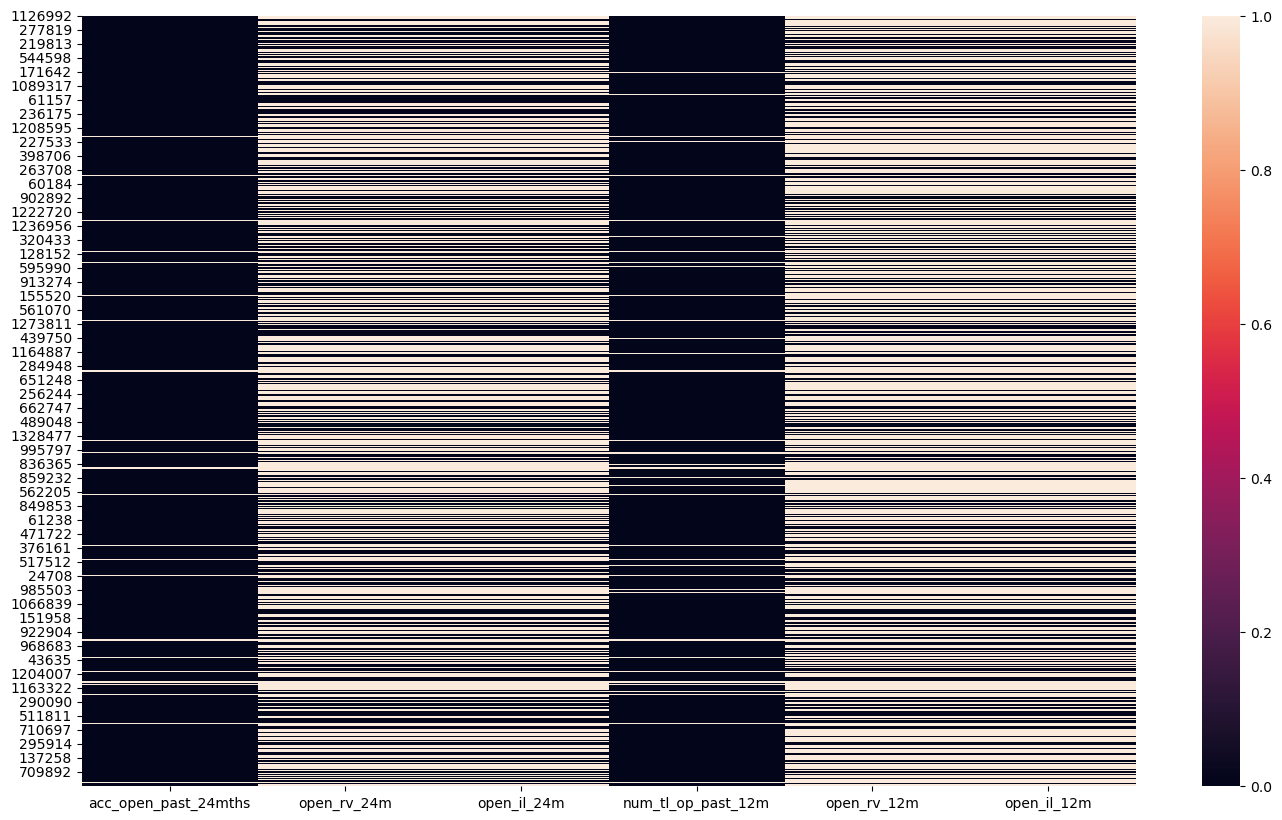

In [79]:
acc_mths = ['acc_open_past_24mths', 'open_rv_24m','open_il_24m','num_tl_op_past_12m', 'open_rv_12m', 'open_il_12m']
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(EDA[acc_mths].isna(), ax=ax)
plt.show()

In [80]:
rv_12m_notna = len(EDA[acc_mths][EDA['open_rv_24m'].isna() & EDA['open_rv_12m'].notna()])
il_12m_notna = len(EDA[acc_mths][EDA['open_il_24m'].isna() & EDA['open_il_12m'].notna()])

print(f'rv24가 na일때 rv12 notna 개수: {rv_12m_notna}\nil24가 na일때 il12 notna 개수: {il_12m_notna}')

rv24가 na일때 rv12 notna 개수: 0
il24가 na일때 il12 notna 개수: 0


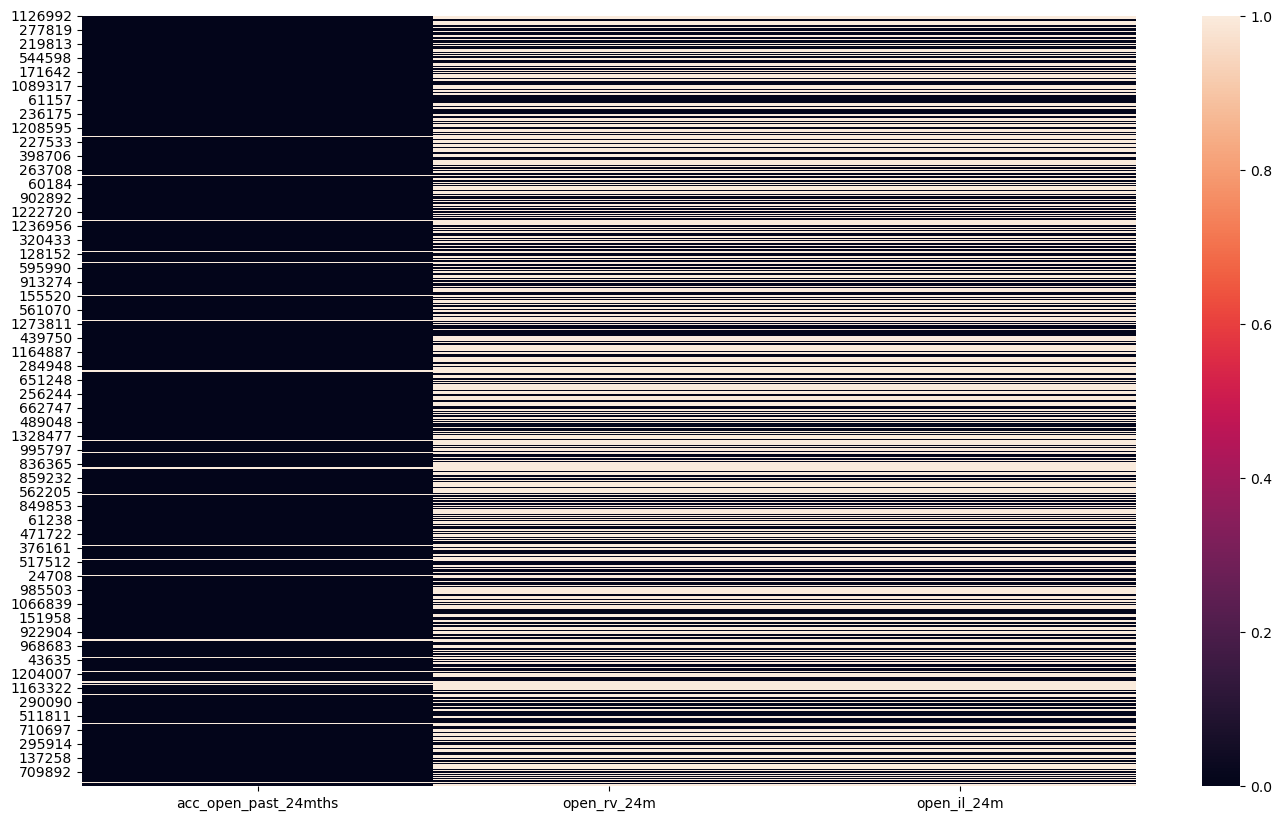

In [81]:
g1 =['acc_open_past_24mths', 'open_rv_24m','open_il_24m']
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(EDA[g1].isna(), ax=ax)
plt.show()

In [82]:
g3

['acc_open_past_24mths',
 'open_rv_24m',
 'open_il_24m',
 'mo_sin_rcnt_tl',
 'mo_sin_rcnt_rev_tl_op',
 'mths_since_rcnt_il']

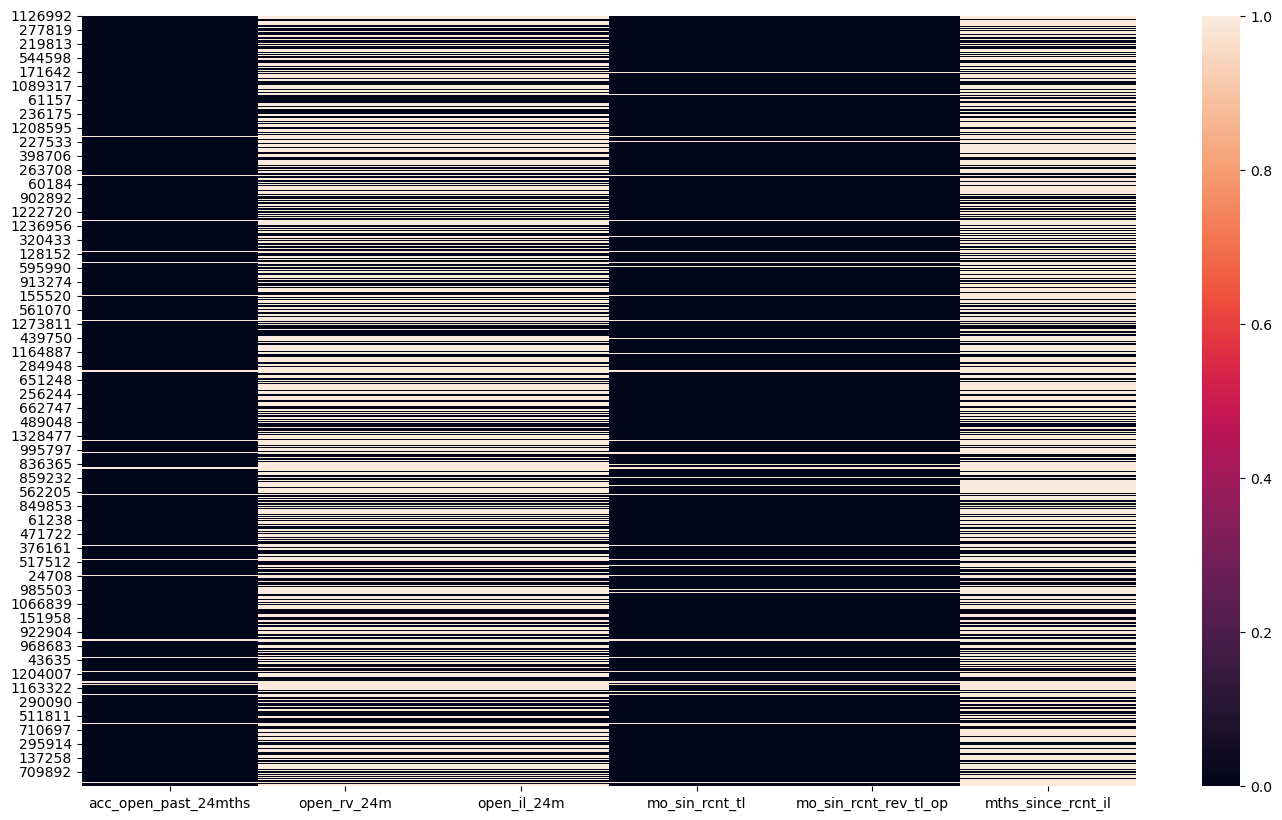

In [83]:
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(EDA[g3].isna(), ax=ax)
plt.show()

In [84]:
# mo_sin_rcnt_tl / mo_sin_rcnt_rev_tl_op 이 오류인 경우. 17091개 열
EDA[g3][(EDA['mo_sin_rcnt_tl']==0)&(EDA['acc_open_past_24mths']!=0)]

,acc_open_past_24mths,open_rv_24m,open_il_24m,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mths_since_rcnt_il
209470,4.0,NaN,NaN,0.0,0.0,NaN
1193106,3.0,1.0,2.0,0.0,0.0,12.0
1158595,16.0,NaN,NaN,0.0,0.0,NaN
372742,4.0,NaN,NaN,0.0,0.0,NaN
1028704,11.0,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...
990016,7.0,5.0,1.0,0.0,0.0,15.0
563465,5.0,4.0,1.0,0.0,0.0,12.0
109963,4.0,NaN,NaN,0.0,0.0,NaN
518414,5.0,3.0,1.0,0.0,0.0,6.0


In [85]:
EDA[g3][( (EDA['mo_sin_rcnt_tl'] != 0) &(EDA['mo_sin_rcnt_rev_tl_op']==0)) & ((EDA['open_rv_24m'] != 0) & (EDA['open_rv_24m'].isna()))]

,acc_open_past_24mths,open_rv_24m,open_il_24m,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mths_since_rcnt_il


In [86]:
EDA[g3][(EDA['mo_sin_rcnt_tl']>24) &(EDA['acc_open_past_24mths'].isna())]

,acc_open_past_24mths,open_rv_24m,open_il_24m,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mths_since_rcnt_il


In [87]:
EDA['acc_open_past_24mths'].isna().sum()

38350

In [88]:
EDA[g3+['total_acc']][(EDA['mo_sin_rcnt_tl'].isna()) & (EDA['acc_open_past_24mths'].isna())]

,acc_open_past_24mths,open_rv_24m,open_il_24m,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mths_since_rcnt_il,total_acc
933637,NaN,NaN,NaN,NaN,NaN,NaN,16.0
919918,NaN,NaN,NaN,NaN,NaN,NaN,38.0
1192171,NaN,NaN,NaN,NaN,NaN,NaN,14.0
953956,NaN,NaN,NaN,NaN,NaN,NaN,20.0
921754,NaN,NaN,NaN,NaN,NaN,NaN,18.0
...,...,...,...,...,...,...,...
925831,NaN,NaN,NaN,NaN,NaN,NaN,29.0
928128,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1186167,NaN,NaN,NaN,NaN,NaN,NaN,17.0
945648,NaN,NaN,NaN,NaN,NaN,NaN,10.0


> acc_open_past_24mths의 결측치 전부 mo_sin_rcnt_tl가 na일 때 발생.
>> 개설여부가 없다는 건데 total_acc에는 있음
>> **즉, 패턴에 의한 결측이 아닌 무작위 결측으로 사료됨**

- acc_open_past_24mths 결측치 제거 (전체 비율의 3.5%이므로 훈련데이터 적은 손실로)

In [89]:
table = PrettyTable()
table.field_names = ["변수명", "결측치 개수", "전체 비율"]


na_cnt = EDA['acc_open_past_24mths'].isna().sum()
total_rows = EDA.shape[0]
ratio = (na_cnt / total_rows) * 100
if na_cnt != 0:
    table.add_row(['acc_open_past_24mths', na_cnt, f'{ratio:.2f}%'])

table

변수명,결측치 개수,전체 비율
acc_open_past_24mths,38350,3.52%


In [90]:
EDA['acc_open_past_24mths'].isna().sum()

38350

In [101]:
# 'acc_open_past_24mths' 열에서 결측치를 가진 행 삭제
EDA.dropna(subset=['acc_open_past_24mths'], inplace=True)

In [105]:
EDA['acc_open_past_24mths'].isna().sum()

0

In [111]:
#3차 결측치처리 후 확인

for col in ['acc_open_past_24mths','open_il_24m','open_rv_24m'] :
    na_cnt = EDA[col].isna().sum()
    total_rows = EDA.shape[0]
    ratio = (na_cnt / total_rows) * 100
    impute_table.add_row([col, na_cnt, f'{ratio:.2f}%'])

impute_table

변수명,결측치 개수,전체 비율
open_rv_24m,571694,52.46%
open_il_24m,571694,52.46%
acc_open_past_24mths,0,0.00%
open_il_24m,533344,50.73%
open_rv_24m,533344,50.73%


#### **최종 결측치 처리**

#total_24 채운뒤 
1. total_24==0이면 fully paid, charged off 0으로 채우기
2. total_24!=0이면 fully paid, charged off 나눠서 값 가지기 

In [114]:
EDA[['acc_open_past_24mths','open_il_24m','open_rv_24m']].describe()

,acc_open_past_24mths,open_il_24m,open_rv_24m
count,1.051351e+06,518007.000000,518007.000000
mean,4.694307e+00,1.699639,2.529242
std,3.190705e+00,1.683701,2.712336
min,0.000000e+00,0.000000,0.000000
25%,2.000000e+00,1.000000,0.000000
50%,4.000000e+00,1.000000,2.000000
75%,6.000000e+00,2.000000,4.000000
max,6.400000e+01,51.000000,53.000000


In [162]:
pd.set_option('display.float_format', '{:.6f}'.format)
EDA[['acc_open_past_24mths','open_il_24m','open_rv_24m']].describe()

,acc_open_past_24mths,open_il_24m,open_rv_24m
count,1051351.000000,1051351.000000,1051351.000000
mean,4.694307,1.954134,2.362885
std,3.190705,1.603554,2.182506
min,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000
50%,4.000000,2.000000,2.000000
75%,6.000000,3.000000,3.000000
max,64.000000,51.000000,53.000000


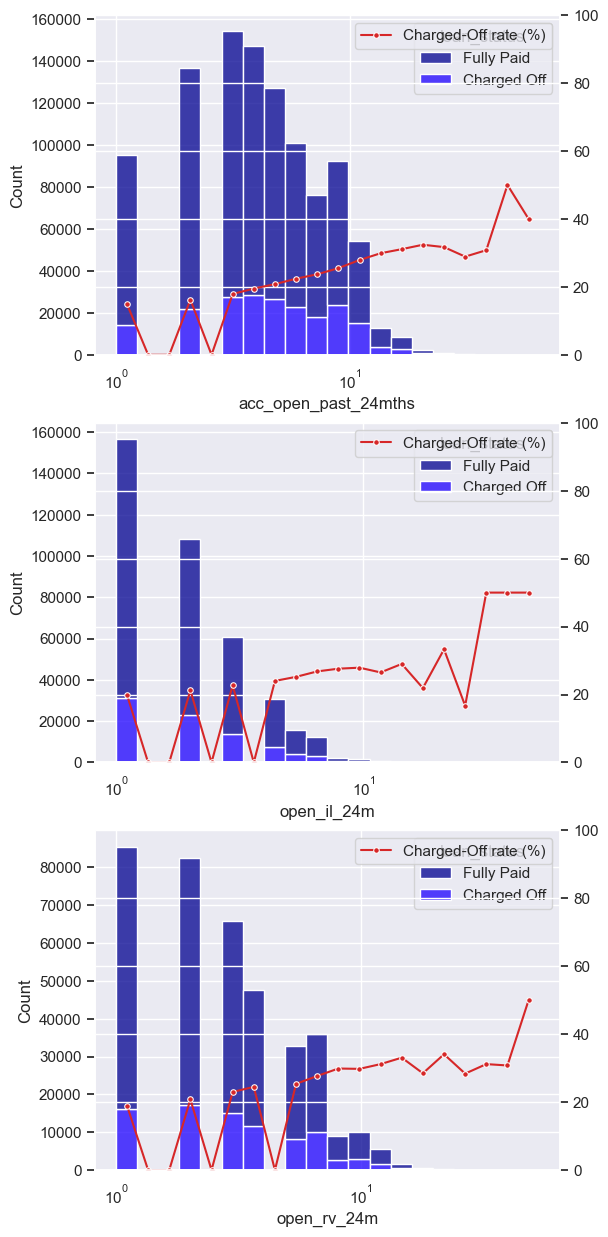

In [145]:
sns.set(palette="gnuplot2")
fig, ax = plt.subplots(3,1,figsize=(6,15))
for idx, col in enumerate(['acc_open_past_24mths','open_il_24m','open_rv_24m']):
    sns.histplot(EDA, x=col, hue="loan_status", bins=20, multiple="stack", log_scale=True, ax=ax[idx])
    charged_off = np.array([bar.get_height() for bar in ax[idx].patches])[:len(ax[idx].patches) // 2]
    fully_paid = np.array([bar.get_height() for bar in ax[idx].patches])[len(ax[idx].patches) // 2:]
    ax2 = ax[idx].twinx()
    ax2.set_ylim(0, 100)
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax[idx].patches][:len(ax[idx].patches) // 2], y=(charged_off / (fully_paid + charged_off + 1) * 100).round(1), 
                    ax=ax2, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")

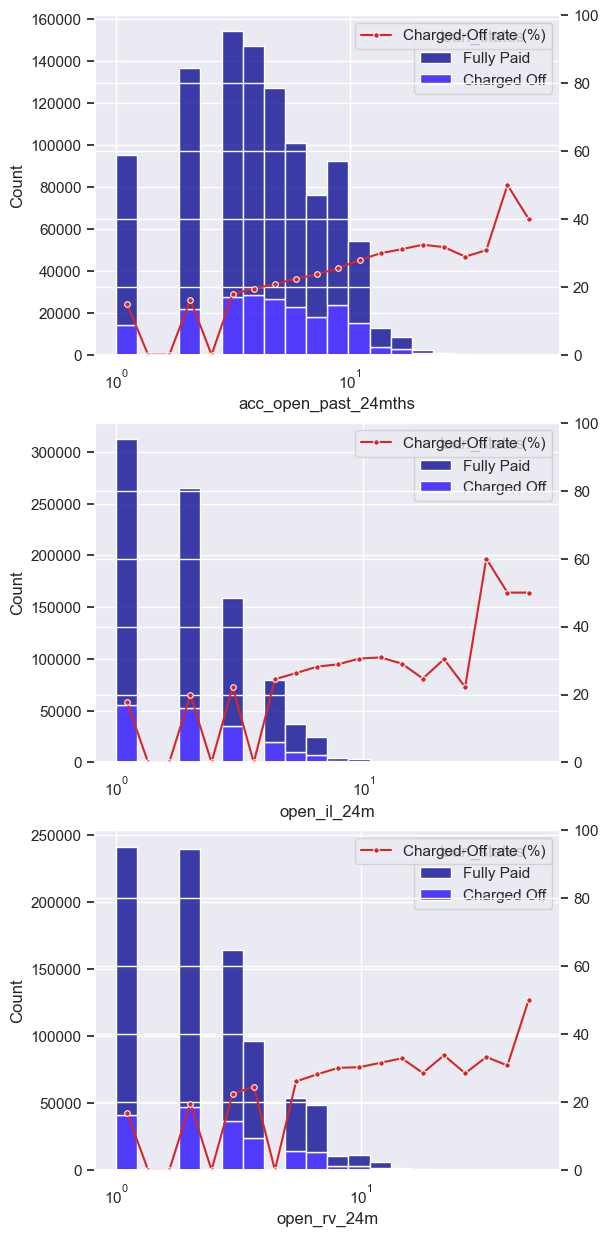

In [155]:
sns.set(palette="gnuplot2")
fig, ax = plt.subplots(3,1,figsize=(6,15))
for idx, col in enumerate(['acc_open_past_24mths','open_il_24m','open_rv_24m']):
    sns.histplot(EDA, x=col, hue="loan_status", bins=20, multiple="stack", log_scale=True, ax=ax[idx])
    charged_off = np.array([bar.get_height() for bar in ax[idx].patches])[:len(ax[idx].patches) // 2]
    fully_paid = np.array([bar.get_height() for bar in ax[idx].patches])[len(ax[idx].patches) // 2:]
    ax2 = ax[idx].twinx()
    ax2.set_ylim(0, 100)
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax[idx].patches][:len(ax[idx].patches) // 2], y=(charged_off / (fully_paid + charged_off + 1) * 100).round(1), 
                    ax=ax2, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")

In [211]:
EDA[['acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_rv_24m']==0] #176952

,acc_open_past_24mths,open_il_24m,open_rv_24m
1126992,1.000000,0.000000,0.000000
37221,1.000000,0.000000,0.000000
1099815,1.000000,1.000000,0.000000
69612,1.000000,0.000000,0.000000
398239,1.000000,1.000000,0.000000
...,...,...,...
1121387,1.000000,0.000000,0.000000
127448,1.000000,1.000000,0.000000
683188,0.000000,0.000000,0.000000
333323,0.000000,0.000000,0.000000


In [217]:
EDA[[target,'acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_il_24m']==0].groupby(target).size() #165128

loan_status
Charged Off     29480
Fully Paid     135648
dtype: int64

In [246]:
EDA[[target,'acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_il_24m']!=0].groupby(target).size() #165128

loan_status
Charged Off    211917
Fully Paid     839434
dtype: int64

In [243]:
EDA[[target,'acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_il_24m']==0].groupby(target).size()

Series([], dtype: int64)

In [256]:
EDA[[target,'acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_rv_24m']==10].groupby(target).size()

loan_status
Charged Off    1313
Fully Paid     3051
dtype: int64

In [221]:
EDA[[target,'acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['acc_open_past_24mths']!=0].groupby(target).size()

loan_status
Charged Off    206048
Fully Paid     803704
dtype: int64

In [218]:
EDA.groupby(target).size()

loan_status
Charged Off    211917
Fully Paid     839434
dtype: int64

In [219]:
EDA[[target,'acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_rv_24m']==0].groupby(target).size() #165128

loan_status
Charged Off     26607
Fully Paid     150345
dtype: int64

In [216]:
EDA[['acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['acc_open_past_24mths']==0] #open_rv_24m

,acc_open_past_24mths,open_il_24m,open_rv_24m
1334676,0.000000,0.000000,0.000000
1112983,0.000000,0.000000,0.000000
597233,0.000000,0.000000,0.000000
9545,0.000000,0.000000,0.000000
1285707,0.000000,0.000000,0.000000
...,...,...,...
1083057,0.000000,0.000000,0.000000
1104459,0.000000,0.000000,0.000000
378090,0.000000,0.000000,0.000000
683188,0.000000,0.000000,0.000000


In [213]:
EDA[['acc_open_past_24mths','open_il_24m','open_rv_24m']][EDA['open_il_24m']!=0] #886223

,acc_open_past_24mths,open_il_24m,open_rv_24m
465057,4.000000,3.000000,1.000000
148918,9.000000,4.000000,4.000000
31145,2.000000,1.000000,1.000000
343684,3.000000,1.000000,1.000000
1140706,3.000000,1.000000,1.000000
...,...,...,...
181250,7.000000,3.000000,3.000000
673511,6.000000,3.000000,3.000000
509553,12.000000,8.000000,4.000000
107784,6.000000,3.000000,3.000000


In [ ]:
#결측 대체 전
fig, ax = plt.subplots(3,1,figsize=(6,15))

for idx, col in enumerate(['acc_open_past_24mths','open_rv_24m', 'open_il_24m']):
    sns.boxplot(data=EDA, x=target, y=col, ax=ax[idx])
    ax[idx].set_title(f"{col} groupby {target}", size=12, weight="bold")
    font2 = { 'color':'royalblue','size':10, 'rotation':360}
    ax[idx].set_xlabel(col,fontdict=font2)

plt.show()

In [132]:
#1. total_24==0이면 'open_rv_24m', 'open_il_24m' 0으로 채우기

EDA.loc[(EDA['acc_open_past_24mths'] == 0) & (EDA['open_rv_24m'].isna()), 'open_rv_24m'] = 0 
EDA.loc[(EDA['acc_open_past_24mths'] == 0) & (EDA['open_il_24m'].isna()), 'open_il_24m'] = 0 

In [133]:
#4차 결측치처리 후 확인

for col in ['acc_open_past_24mths','open_il_24m','open_rv_24m'] :
    na_cnt = EDA[col].isna().sum()
    total_rows = EDA.shape[0]
    ratio = (na_cnt / total_rows) * 100
    impute_table.add_row([f'4차 {col}', na_cnt, f'{ratio:.2f}%'])

impute_table

변수명,결측치 개수,전체 비율
open_rv_24m,571694,52.46%
open_il_24m,571694,52.46%
acc_open_past_24mths,0,0.00%
open_il_24m,533344,50.73%
open_rv_24m,533344,50.73%
4차 acc_open_past_24mths,0,0.00%
4차 open_il_24m,532432,50.64%
4차 open_rv_24m,532432,50.64%


In [146]:
EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_rv_24m'].isna()), 'acc_open_past_24mths']

1126992     1.0
148918      9.0
31145       2.0
37221       1.0
343684      3.0
           ... 
181250      7.0
109985      1.0
673511      6.0
107784      6.0
162341     10.0
Name: acc_open_past_24mths, Length: 532432, dtype: float64

In [148]:
3//2

1

In [149]:
#2. total_24!=0이면 fully paid, charged off 나눠서 값 가지기 

EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_rv_24m'].isna()),'open_rv_24m'] = EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_rv_24m'].isna()),'acc_open_past_24mths'] // 2
EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_il_24m'].isna()),'open_il_24m'] = EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_il_24m'].isna()),'acc_open_past_24mths'] // 2

In [135]:
#스케일 차이가 나 사용 못할 듯 
g4 = ['acc_open_past_24mths','open_il_24m','open_rv_24m', 'num_rev_accts','num_il_tl','mort_acc']
EDA[g4].sample(20)

,acc_open_past_24mths,open_il_24m,open_rv_24m,num_rev_accts,num_il_tl,mort_acc
117221,2.0,2.0,0.0,12.0,10.0,0.0
1245608,6.0,3.0,2.0,6.0,32.0,1.0
1246264,3.0,2.0,1.0,5.0,6.0,2.0
340830,2.0,2.0,0.0,7.0,6.0,0.0
809231,3.0,NaN,NaN,24.0,7.0,3.0
291411,2.0,2.0,0.0,11.0,9.0,3.0
821261,6.0,NaN,NaN,22.0,5.0,0.0
1020871,1.0,1.0,0.0,21.0,6.0,10.0
839060,5.0,NaN,NaN,8.0,1.0,0.0
535389,2.0,0.0,2.0,23.0,2.0,1.0


In [153]:
#최종 결측치처리 후 확인

for col in ['acc_open_past_24mths','open_il_24m','open_rv_24m'] :
    na_cnt = EDA[col].isna().sum()
    total_rows = EDA.shape[0]
    ratio = (na_cnt / total_rows) * 100
    impute_table.add_row([f'최종 {col}', na_cnt, f'{ratio:.2f}%'])

impute_table

변수명,결측치 개수,전체 비율
open_rv_24m,571694,52.46%
open_il_24m,571694,52.46%
acc_open_past_24mths,0,0.00%
open_il_24m,533344,50.73%
open_rv_24m,533344,50.73%
4차 acc_open_past_24mths,0,0.00%
4차 open_il_24m,532432,50.64%
4차 open_rv_24m,532432,50.64%
최종 acc_open_past_24mths,0,0.00%
최종 open_il_24m,0,0.00%


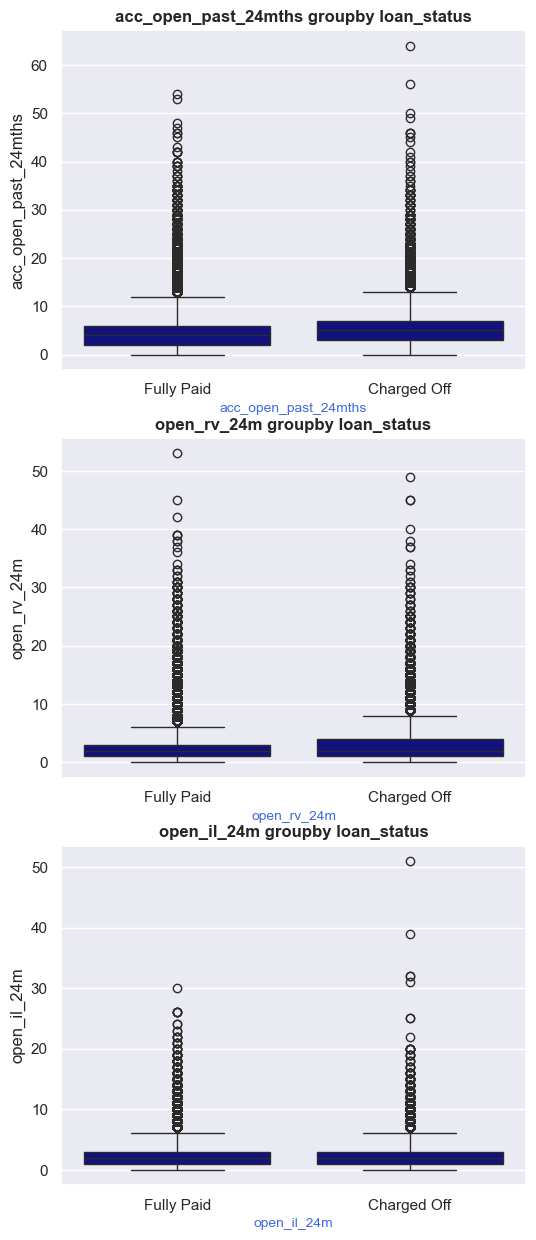

In [154]:
#결측 대체 후
fig, ax = plt.subplots(3,1,figsize=(6,15))

for idx, col in enumerate(['acc_open_past_24mths','open_rv_24m', 'open_il_24m']):
    sns.boxplot(data=EDA, x=target, y=col, ax=ax[idx])
    ax[idx].set_title(f"{col} groupby {target}", size=12, weight="bold")
    font2 = { 'color':'royalblue','size':10, 'rotation':360}
    ax[idx].set_xlabel(col,fontdict=font2)

plt.show()

### 5-6. num_actv_bc_tl, num_actv_rev_tl 5.02%의 결측 

#### 다른 변수와의 관계

- 활성상태의 정의 : il, bc의 경우 잔액이 0이상 일떄 
1. 'num_il_tl'(개설(open)된 il 수)중에 활성상태 수 : 'open_act_il'
2.  'num_op_rev_tl' (개설(open)된 rev 수)중에 리볼빙 활성상태 수: 'num_actv_rev_tl'
3.  'num_bc_tl' (개살(open)된 bc 수)중에 활성상태 수 : 'num_actv_bc_tl'

In [433]:
count = ['num_il_tl', 'open_act_il', 'num_op_rev_tl', 'num_actv_rev_tl', 'num_bc_tl', 'num_actv_bc_tl']
act_count = ['open_act_il', 'num_actv_rev_tl','num_actv_bc_tl']

In [456]:
EDA[count+['mort_acc','num_sats','open_acc']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1051351 entries, 1126992 to 162341
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   num_il_tl        1035025 non-null  float64
 1   open_act_il      435673 non-null   float64
 2   num_op_rev_tl    1035025 non-null  float64
 3   num_actv_rev_tl  1035025 non-null  float64
 4   num_bc_tl        1035025 non-null  float64
 5   num_actv_bc_tl   1035025 non-null  float64
 6   mort_acc         1051351 non-null  float64
 7   num_sats         1044431 non-null  float64
 8   open_acc         1051351 non-null  float64
dtypes: float64(9)
memory usage: 112.5 MB


In [440]:
len(EDA)
#435673 건 중에

#110120
#44393

#더큼 105345
#더 작음 285935

1051351

In [452]:
EDA[act_count+['mort_acc','num_sats','open_acc']][EDA['open_acc']==(EDA['mort_acc']+EDA['num_actv_rev_tl']+EDA['num_actv_bc_tl']+EDA['open_act_il'])]

,open_act_il,num_actv_rev_tl,num_actv_bc_tl,mort_acc,num_sats,open_acc
624084,6.000000,2.000000,1.000000,0.000000,9.000000,9.000000
988003,2.000000,6.000000,5.000000,2.000000,15.000000,15.000000
900712,1.000000,2.000000,1.000000,0.000000,4.000000,4.000000
958430,2.000000,1.000000,1.000000,2.000000,6.000000,6.000000
584037,1.000000,5.000000,3.000000,0.000000,9.000000,9.000000
...,...,...,...,...,...,...
1286258,1.000000,5.000000,5.000000,4.000000,15.000000,15.000000
380671,8.000000,3.000000,0.000000,1.000000,12.000000,12.000000
633589,3.000000,3.000000,2.000000,4.000000,12.000000,12.000000
449727,3.000000,1.000000,1.000000,0.000000,5.000000,5.000000


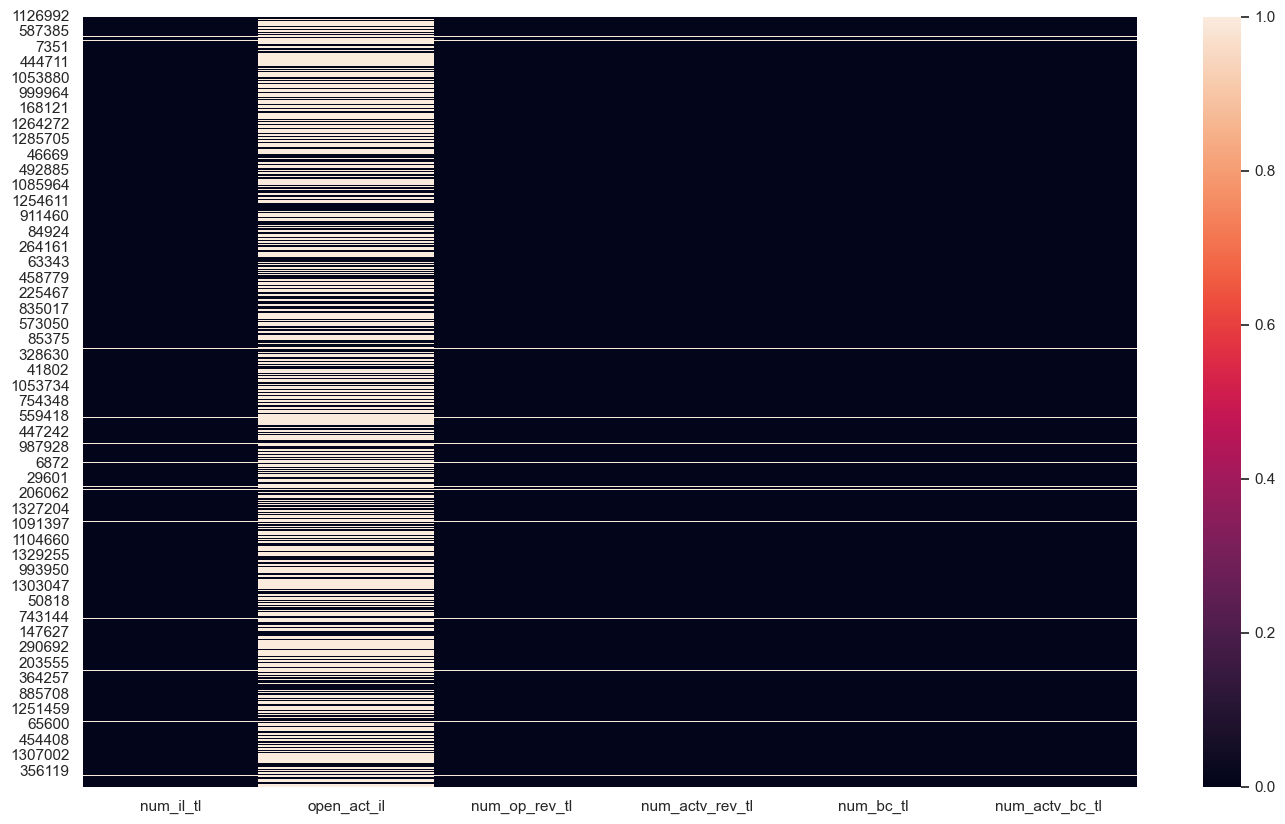

In [453]:
fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(EDA[count].isna(), ax=ax)
plt.show()

In [454]:
#결측의 의미 파악

In [457]:
EDA[act_count+['mort_acc','num_sats','open_acc']][EDA['open_acc']==0]

,open_act_il,num_actv_rev_tl,num_actv_bc_tl,mort_acc,num_sats,open_acc
917828,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1273474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065828,NaN,0.000000,0.000000,1.000000,0.000000,0.000000
520897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
893204,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
382812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
857114,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1110688,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
854892,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


In [476]:
EDA[['hardship_status','debt_settlement_flag_date','hardship_start_date','issue_d','last_pymnt_d','debt_settlement_flag_date','settlement_date','last_pymnt_d']][EDA['debt_settlement_flag_date'].notna()&EDA['hardship_start_date'].notna()].sample(20)

,hardship_status,debt_settlement_flag_date,hardship_start_date,issue_d,last_pymnt_d,debt_settlement_flag_date,settlement_date,last_pymnt_d
193443,COMPLETED,Apr-2018,Jun-2017,Jul-2015,Sep-2017,Apr-2018,Mar-2018,Sep-2017
95368,BROKEN,Apr-2018,Oct-2017,Oct-2015,Feb-2018,Apr-2018,Dec-2017,Feb-2018
553726,BROKEN,Jul-2018,Feb-2018,Apr-2017,Mar-2018,Jul-2018,Jun-2018,Mar-2018
623589,BROKEN,Nov-2017,Jun-2017,Feb-2016,Aug-2017,Nov-2017,Oct-2017,Aug-2017
542608,COMPLETED,Sep-2018,Sep-2017,May-2017,Feb-2018,Sep-2018,Aug-2018,Feb-2018
232792,BROKEN,Oct-2018,Sep-2017,Jun-2015,Oct-2017,Oct-2018,Jan-2018,Oct-2017
157846,COMPLETED,Jul-2018,Sep-2017,Aug-2015,Jan-2018,Jul-2018,Jul-2018,Jan-2018
1339400,COMPLETED,Dec-2018,Sep-2017,Oct-2016,Nov-2017,Dec-2018,Jul-2018,Nov-2017
1244800,COMPLETED,Dec-2018,Sep-2017,Jul-2016,Aug-2018,Dec-2018,Jul-2018,Aug-2018
667844,BROKEN,Nov-2018,Mar-2018,Jan-2016,Apr-2018,Nov-2018,Oct-2018,Apr-2018


#### 활성상태의 정의 : il, bc의 경우 잔액이 0이상 일떄  검증
- rev 는 0이상일 때도 활성일 수 있다고..

In [468]:
#il 오류 : 2570
EDA[['total_bal_il',  'num_il_tl', 'open_act_il']][(EDA['total_bal_il']!=0)&(EDA['open_act_il']==0)]

,total_bal_il,num_il_tl,open_act_il
550021,5321.000000,1.000000,0.000000
414045,3288.000000,13.000000,0.000000
624146,13009.000000,2.000000,0.000000
614071,7174.000000,1.000000,0.000000
498579,4393.000000,2.000000,0.000000
...,...,...,...
1240681,12964.000000,1.000000,0.000000
597067,21288.000000,10.000000,0.000000
607589,74680.000000,3.000000,0.000000
1226169,19306.000000,2.000000,0.000000


In [465]:
#bc 오류 : 10873
EDA[['bc_open_to_buy', 'num_bc_tl', 'num_actv_bc_tl']][(EDA['bc_open_to_buy']!=0)& (EDA['num_actv_bc_tl']==0)&(EDA['bc_open_to_buy'].notna())]

,bc_open_to_buy,num_bc_tl,num_actv_bc_tl
1269054,6100.000000,4.000000,0.000000
1308067,8500.000000,4.000000,0.000000
374492,3900.000000,2.000000,0.000000
1155820,11900.000000,17.000000,0.000000
422160,4500.000000,4.000000,0.000000
...,...,...,...
19406,8400.000000,4.000000,0.000000
673428,2000.000000,5.000000,0.000000
415163,1600.000000,3.000000,0.000000
994291,1900.000000,2.000000,0.000000


In [467]:
#revol 오류 : 90
EDA[['bc_open_to_buy','revol_bal','num_op_rev_tl','num_actv_rev_tl']][(EDA['revol_bal']!=0)&(EDA['num_actv_rev_tl']==0)]

,bc_open_to_buy,revol_bal,num_op_rev_tl,num_actv_rev_tl
371220,13900.000000,602.000000,6.000000,0.000000
291733,NaN,18834.000000,4.000000,0.000000
1265949,15700.000000,6789.000000,8.000000,0.000000
1261121,29450.000000,3650.000000,21.000000,0.000000
1267414,71596.000000,4.000000,13.000000,0.000000
...,...,...,...,...
1237665,9.000000,991.000000,1.000000,0.000000
422344,1000.000000,41707.000000,2.000000,0.000000
1193616,3300.000000,107.000000,3.000000,0.000000
914313,7000.000000,1083.000000,7.000000,0.000000


In [360]:
#bc가 rev하고 독립적인 근거
EDA[['num_op_rev_tl','num_bc_tl']][EDA['num_bc_tl']>EDA['num_op_rev_tl']]

,num_op_rev_tl,num_bc_tl
1126992,7.000000,8.000000
1140706,6.000000,12.000000
290496,8.000000,9.000000
624084,3.000000,4.000000
185307,2.000000,9.000000
...,...,...
101371,3.000000,4.000000
683188,3.000000,4.000000
181250,8.000000,11.000000
109985,15.000000,24.000000


In [ ]:
# bc가 할부에 속한다 xx
# bc가 rev에 속한다 xx
# bc | rev | installment 로 독립된다 ㅇㅇ

#### 밸런스 검증 (il 밸런스 결측 처리)

- total_bal_ex_mort = total_bal_il + revol_bal
- bal = 'bc_open_to_buy', 'total_bal_ex_mort','total_bal_il','revol_bal'


In [404]:
bal = ['bc_open_to_buy', 'total_bal_ex_mort','total_bal_il','revol_bal']

In [417]:
len_bal = len(EDA[bal])
tot_na = len(EDA[bal][EDA['total_bal_il'].isna()])+ len(EDA[bal][EDA['revol_bal'].isna()])
equal = len(EDA[bal][EDA['total_bal_ex_mort'] == (EDA['total_bal_il']+EDA['revol_bal'])]) + len(EDA[bal][(EDA['total_bal_ex_mort'] == EDA['revol_bal'])&(EDA['total_bal_il'].isna())])
eq_rev = len(EDA[bal][(EDA['total_bal_ex_mort'] == EDA['revol_bal'])&(EDA['total_bal_il'].isna())])

print(f'총 길이: {len_bal}')
print(f'결측값: {tot_na}')
print(f'논리에 맞는 수: {equal}')
print(f'값이 있는 것 중에 논리의 맞지 않는 경우: {(len_bal-tot_na+eq_rev)-equal}')

총 길이: 1051351
결측값: 615678
논리에 맞는 수: 478571
값이 있는 것 중에 논리의 맞지 않는 경우: 32872


In [414]:
EDA[bal][(EDA['total_bal_ex_mort'] == (EDA['total_bal_il']+EDA['revol_bal']))]

,bc_open_to_buy,total_bal_ex_mort,total_bal_il,revol_bal
530674,8899.000000,26159.000000,7436.000000,18723.000000
465057,9377.000000,131188.000000,126565.000000,4623.000000
624084,959.000000,32784.000000,30857.000000,1927.000000
1304592,10874.000000,13926.000000,11342.000000,2584.000000
482171,8779.000000,61512.000000,54984.000000,6528.000000
...,...,...,...,...
1304339,21114.000000,24988.000000,15472.000000,9516.000000
558495,41648.000000,116340.000000,78349.000000,37991.000000
516925,19762.000000,50511.000000,48435.000000,2076.000000
987480,520.000000,26269.000000,17962.000000,8307.000000


In [416]:
EDA[bal][(EDA['total_bal_ex_mort'] == EDA['revol_bal'])&(EDA['total_bal_il'].isna())]

,bc_open_to_buy,total_bal_ex_mort,total_bal_il,revol_bal
1126992,2245.000000,18861.000000,NaN,18861.000000
209470,29852.000000,15748.000000,NaN,15748.000000
69612,25926.000000,7207.000000,NaN,7207.000000
171993,7878.000000,11985.000000,NaN,11985.000000
176052,6481.000000,23945.000000,NaN,23945.000000
...,...,...,...,...
724040,20969.000000,6467.000000,NaN,6467.000000
151235,4888.000000,11242.000000,NaN,11242.000000
683188,2069.000000,6162.000000,NaN,6162.000000
109985,85886.000000,43115.000000,NaN,43115.000000


In [418]:
EDA[bal][EDA['total_bal_ex_mort'] != (EDA['total_bal_il']+EDA['revol_bal'])]

,bc_open_to_buy,total_bal_ex_mort,total_bal_il,revol_bal
1126992,2245.000000,18861.000000,NaN,18861.000000
148918,12003.000000,76482.000000,NaN,11011.000000
31145,3351.000000,46069.000000,NaN,37090.000000
37221,352.000000,6762.000000,NaN,4148.000000
343684,276.000000,21526.000000,NaN,14724.000000
...,...,...,...,...
181250,3054.000000,115921.000000,NaN,30778.000000
109985,85886.000000,43115.000000,NaN,43115.000000
673511,3507.000000,55593.000000,NaN,16977.000000
107784,18036.000000,81765.000000,NaN,20946.000000


In [335]:
EDA[['bc_open_to_buy', 'total_bal_il']][EDA['total_bal_il']<EDA['bc_open_to_buy']]

,bc_open_to_buy,total_bal_il
530674,8899.000000,7436.000000
1325819,19036.000000,11192.000000
915473,33616.000000,32504.000000
1193106,4585.000000,3282.000000
510608,4290.000000,0.000000
...,...,...
897591,3288.000000,0.000000
958672,2082.000000,0.000000
998942,22018.000000,7258.000000
378090,1996.000000,0.000000


In [326]:
EDA[['bc_open_to_buy', 'total_bal_ex_mort','total_bal_il','revol_bal']][EDA['total_bal_ex_mort']!=EDA['total_bal_il']+EDA['revol_bal']]

,bc_open_to_buy,total_bal_ex_mort,total_bal_il,revol_bal
1126992,2245.000000,18861.000000,NaN,18861.000000
148918,12003.000000,76482.000000,NaN,11011.000000
31145,3351.000000,46069.000000,NaN,37090.000000
37221,352.000000,6762.000000,NaN,4148.000000
343684,276.000000,21526.000000,NaN,14724.000000
...,...,...,...,...
181250,3054.000000,115921.000000,NaN,30778.000000
109985,85886.000000,43115.000000,NaN,43115.000000
673511,3507.000000,55593.000000,NaN,16977.000000
107784,18036.000000,81765.000000,NaN,20946.000000


In [330]:
EDA[['bc_open_to_buy', 'total_bal_ex_mort','total_bal_il','revol_bal']][EDA['total_bal_il'].isna()]

,bc_open_to_buy,total_bal_ex_mort,total_bal_il,revol_bal
1126992,2245.000000,18861.000000,NaN,18861.000000
148918,12003.000000,76482.000000,NaN,11011.000000
31145,3351.000000,46069.000000,NaN,37090.000000
37221,352.000000,6762.000000,NaN,4148.000000
343684,276.000000,21526.000000,NaN,14724.000000
...,...,...,...,...
181250,3054.000000,115921.000000,NaN,30778.000000
109985,85886.000000,43115.000000,NaN,43115.000000
673511,3507.000000,55593.000000,NaN,16977.000000
107784,18036.000000,81765.000000,NaN,20946.000000


In [420]:
EDA[bal].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1051351 entries, 1126992 to 162341
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   bc_open_to_buy     1040048 non-null  float64
 1   total_bal_ex_mort  1051351 non-null  float64
 2   total_bal_il       435673 non-null   float64
 3   revol_bal          1051351 non-null  float64
dtypes: float64(4)
memory usage: 40.1 MB


##### total_bal_il 결측치 처리 

In [421]:
EDA.loc[EDA['total_bal_il'].isna(), 'total_bal_il'] = EDA['total_bal_ex_mort'] - EDA['revol_bal']

In [423]:
EDA[bal].sample(20)

,bc_open_to_buy,total_bal_ex_mort,total_bal_il,revol_bal
1030775,6440.000000,6966.000000,0.000000,6966.000000
446606,5184.000000,112445.000000,106129.000000,6316.000000
371629,1591.000000,10199.000000,0.000000,10199.000000
287557,3138.000000,47690.000000,24696.000000,22994.000000
377109,43740.000000,146972.000000,115206.000000,31766.000000
683629,7417.000000,24153.000000,9187.000000,14966.000000
1328573,5414.000000,18081.000000,8679.000000,9402.000000
1165771,997.000000,13887.000000,5881.000000,8006.000000
1258148,13281.000000,7167.000000,2848.000000,4319.000000
158366,1112.000000,13183.000000,0.000000,13183.000000


### 7-9. revol_util, bc_util, il_util의 결측

In [ ]:
'num_il_tl','total_bal_il','open_act_il','num_rev_tl_bal_gt_0','num_op_rev_tl','num_actv_rev_tl','revol_bal','num_bc_tl','num_actv_bc_tl'

### ✅ 6. bc / rev 
- **total_limit**
- tot_hi_cred_lim :모든 신용 한도 총액
- total_bc_limit : 신용카드_총 한도 총액

- **max_limit**
- total_il_high_credit_limit : 할부_ 개인 대출 계좌 **최대** 신용 한도 총액
- total_rev_hi_lim : 리볼빙_대출 계좌의 **최대** 신용 한도
- bc_open_to_buy: 남은 카드 잔액(많은수록 좋음)
- max_bal_bc: 현재 리볼빙_신용카드 중 최대 잔액

- total_bal_ex_mort: 주택 담보 대출을 제외한 총 신용 잔액
- total_bal_il: 모든 할부 계정의 현재 잔액: 남은 상환 금액
- revol_bal : 리볼빙_대출 잔액 : 남은 리볼빙 상환 금액


In [94]:
EDA[['tot_hi_cred_lim','total_bc_limit','total_il_high_credit_limit','total_rev_hi_lim','bc_open_to_buy','max_bal_bc','total_bal_ex_mort','total_bal_il','revol_bal']].sample(20)

,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,bc_open_to_buy,max_bal_bc,total_bal_ex_mort,total_bal_il,revol_bal
1055383,96452.0,33100.0,48167.0,48200.0,10799.0,NaN,70843.0,NaN,23674.0
64215,34200.0,12200.0,22000.0,12200.0,3358.0,NaN,30279.0,NaN,8842.0
955886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11194.0
373891,382300.0,43200.0,51100.0,43200.0,29810.0,NaN,51816.0,NaN,13390.0
445205,39004.0,18000.0,18955.0,19900.0,10215.0,4540.0,17355.0,9026.0,8180.0
811595,95791.0,13200.0,70591.0,25200.0,4626.0,NaN,90265.0,NaN,16350.0
346012,114712.0,2400.0,104112.0,10600.0,602.0,NaN,100468.0,NaN,6809.0
114692,207548.0,42500.0,62812.0,50900.0,22480.0,NaN,75446.0,NaN,24017.0
500469,282946.0,34400.0,33969.0,52600.0,20383.0,3581.0,40312.0,26015.0,14297.0
768453,314262.0,9700.0,47625.0,19900.0,327.0,NaN,46819.0,NaN,16323.0


In [95]:
#EDA['total_bc_limit']가 EDA['total_il_high_credit_limit']에 포함되는 건 아님
# 독립적인 컬럼으로 판단됨
EDA[['total_bc_limit','total_il_high_credit_limit']][EDA['total_bc_limit']>EDA['total_il_high_credit_limit']]

,total_bc_limit,total_il_high_credit_limit
1126992,18700.0,0.0
530674,19700.0,13000.0
31145,40000.0,31014.0
290496,14900.0,11394.0
209470,45600.0,0.0
...,...,...
127448,105400.0,31970.0
744688,14800.0,14654.0
683188,7700.0,0.0
109985,122900.0,0.0


In [96]:
EDA[['total_bc_limit','total_il_high_credit_limit']][EDA['total_bc_limit']<EDA['total_il_high_credit_limit']]

,total_bc_limit,total_il_high_credit_limit
465057,14000.0,125196.0
148918,16300.0,66853.0
37221,4500.0,5401.0
343684,15000.0,24247.0
1140706,15400.0,62513.0
...,...,...
1101742,10100.0,29325.0
181250,32900.0,104091.0
673511,14800.0,47989.0
509553,31000.0,187950.0


In [97]:
#EDA['total_il_high_credit_limit']가 EDA['total_rev_hi_lim']보다 전부 작음

EDA[['total_il_high_credit_limit','total_rev_hi_lim']][EDA['total_il_high_credit_limit']>EDA['total_rev_hi_lim']]

,total_il_high_credit_limit,total_rev_hi_lim
465057,125196.0,15400.0
148918,66853.0,36700.0
37221,5401.0,4500.0
343684,24247.0,16000.0
1140706,62513.0,20600.0
...,...,...
1101742,29325.0,17800.0
181250,104091.0,34871.0
673511,47989.0,28300.0
509553,187950.0,33500.0


In [98]:
#EDA['total_bc_limit']가 EDA['total_rev_hi_lim']보다 전부 작음

EDA[['total_bc_limit','total_rev_hi_lim']][EDA['total_bc_limit']<=EDA['total_rev_hi_lim']]

,total_bc_limit,total_rev_hi_lim
1126992,18700.0,21600.0
530674,19700.0,47000.0
465057,14000.0,15400.0
148918,16300.0,36700.0
31145,40000.0,44000.0
...,...,...
109985,122900.0,134400.0
673511,14800.0,28300.0
509553,31000.0,33500.0
107784,35900.0,50100.0


# 이상치 탐색
- 스케일링 방법 (로그 스케일, RobustScaler() 등)
- 제거할 이상치
